In [2]:
import matplotlib.pyplot as plt
import os

plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore')

from func import filters as fil
from func import Crop, Calc, Load, Fitting, FWHM

### Data Loading

In [3]:
dir = r'c:\Users\plyslab\Desktop\VNA Automation\Data\Spin_pumping\1_Port_MgO5NiFe20Mgo15_0o_0.3-15.0_GHz_@_-1000.0-1000.0_Oe'
Info, freq, field, RefS11, S11 = Load.NPZ_1P(dir)

#### SET FREQUENCY AND FIELD BOUNDS

In [4]:
lower_freq = 1.5
upper_freq = 5
lower_field = -400
upper_field = 400

In [5]:
freq_used = Crop.cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[2]

field_used = Crop.cut_field(field, lower_field, upper_field)[0]
lower_field = Crop.cut_freq(field, lower_field, upper_field)[1]
upper_field = Crop.cut_freq(field, lower_field, upper_field)[2]

### Filtering Data

In [6]:
abspow = Calc.AbsPower1P(S11, RefS11)
    
filteredData = fil.Filter_Spline(abspow, a=0.1)
filteredData = fil.FilterBG_Median(filteredData)
filteredData = fil.FilterBG_MedianH(filteredData)

cutData = filteredData[lower_freq:upper_freq, lower_field:upper_field]


### Full Width Half Maximum (approx)

FWHM: 16.388587447079573
FWHM: 15.78864683565692


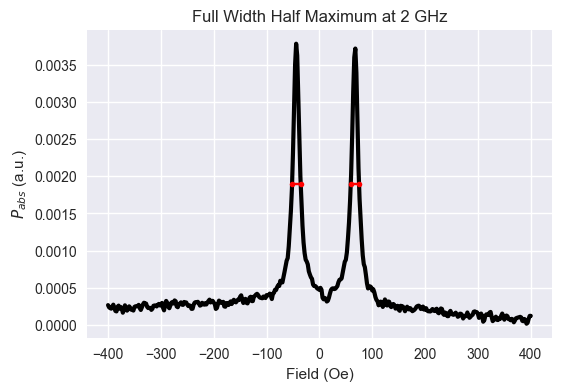

FWHM: 30.888184220577017
FWHM: 26.987242625459857


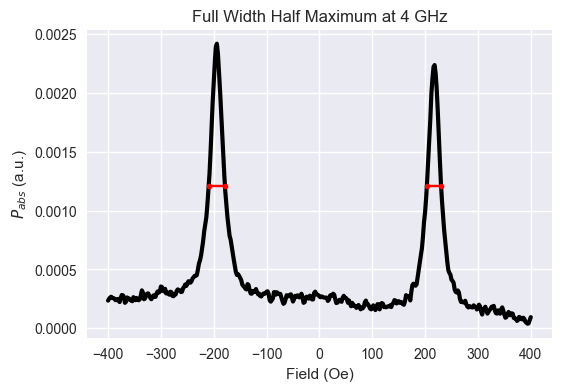

In [7]:
FWHM.fwhm(cutData, field_used, frequency=2, freq_used=freq_used)
FWHM.fwhm(cutData, field_used, frequency=4, freq_used=freq_used)

### Lorentzian Fitting

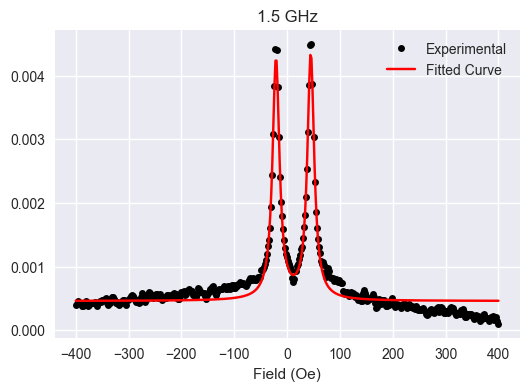

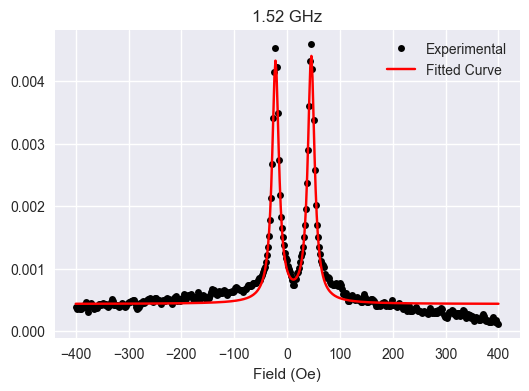

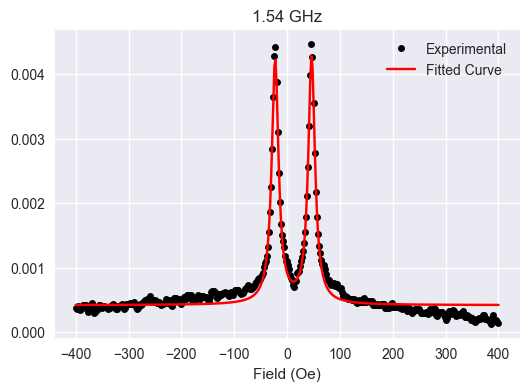

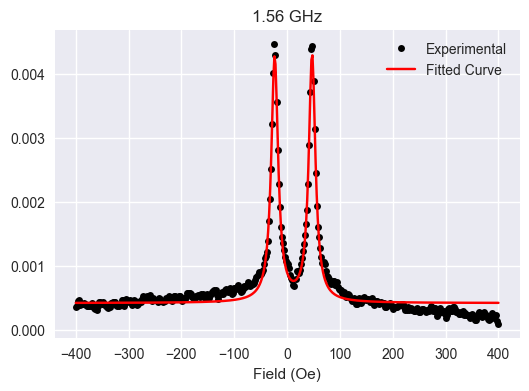

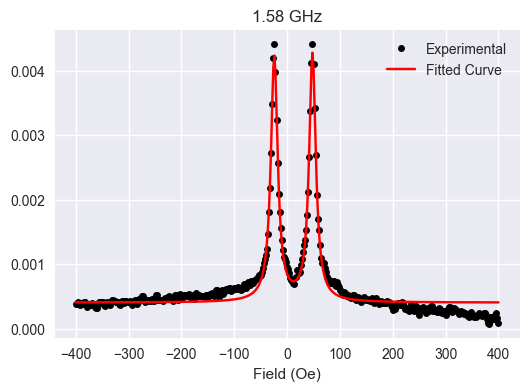

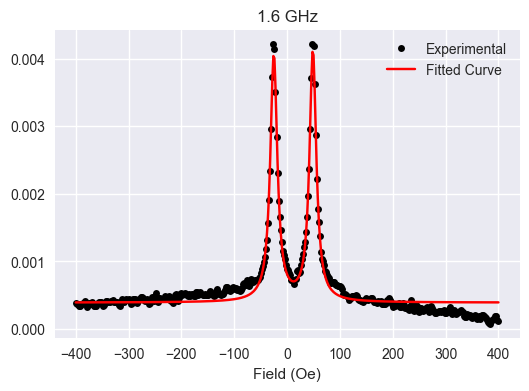

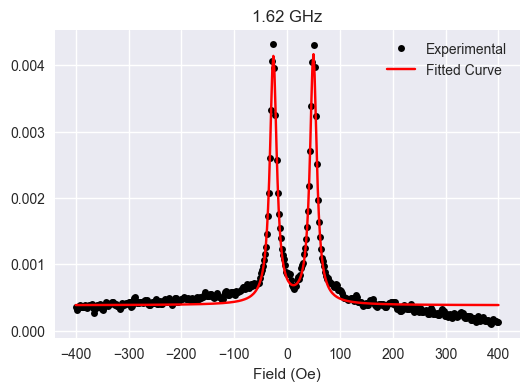

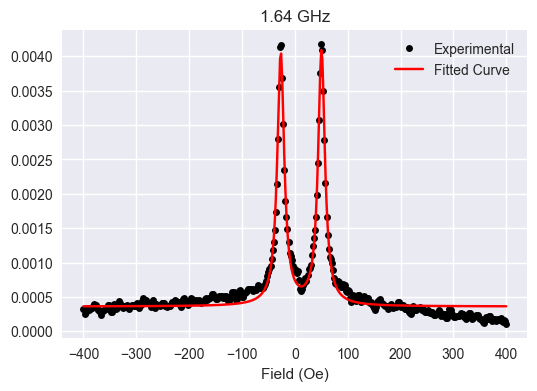

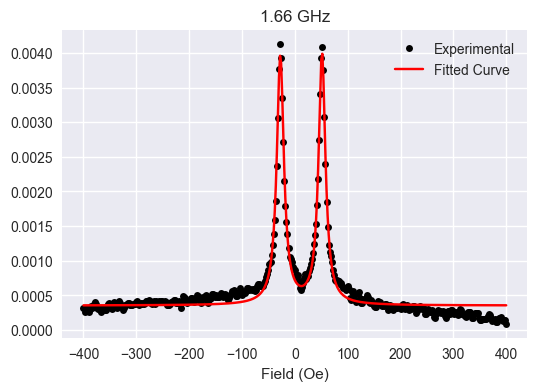

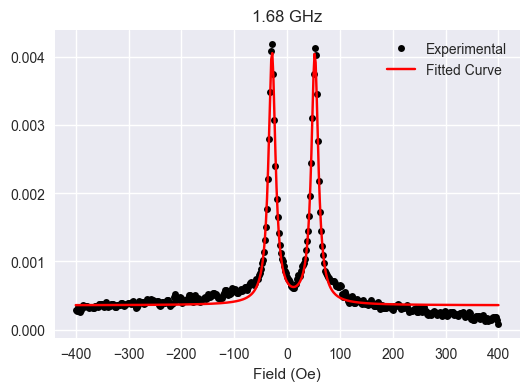

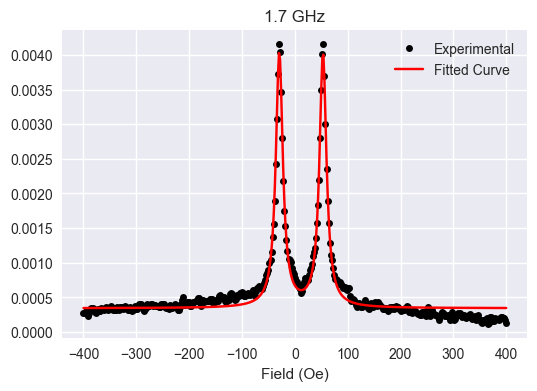

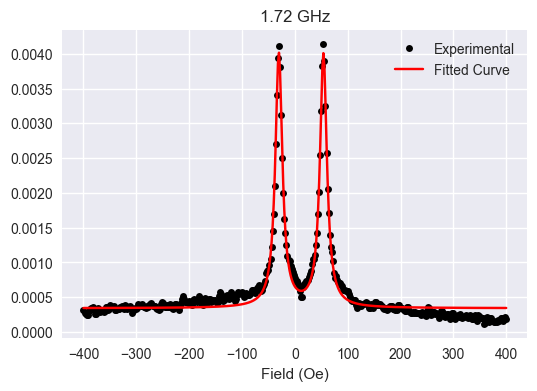

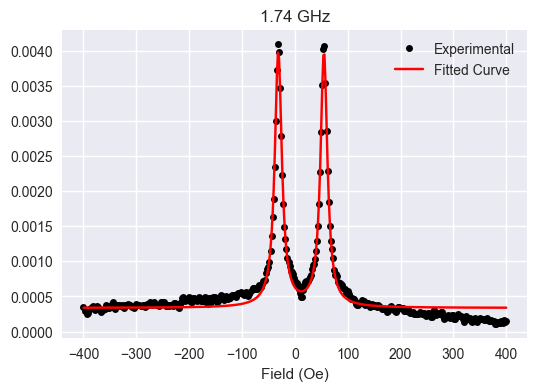

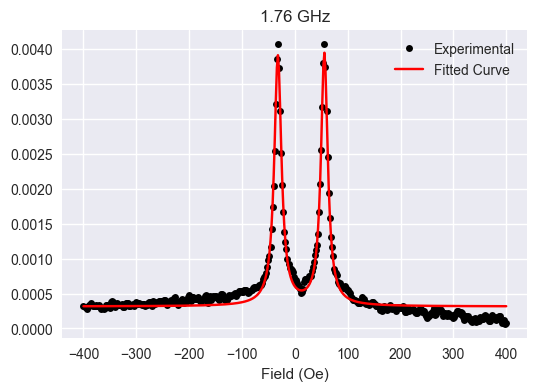

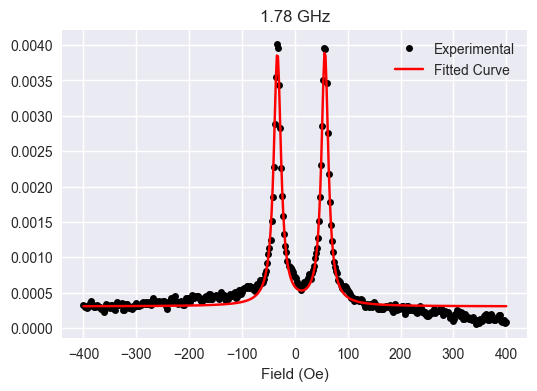

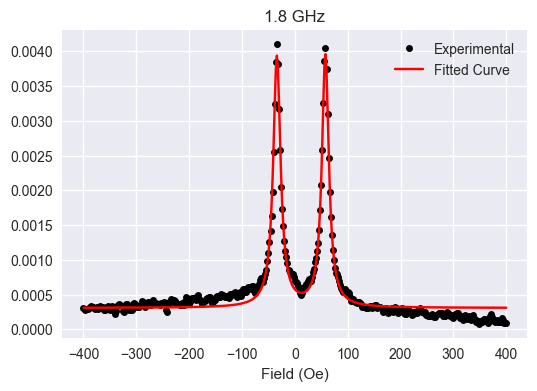

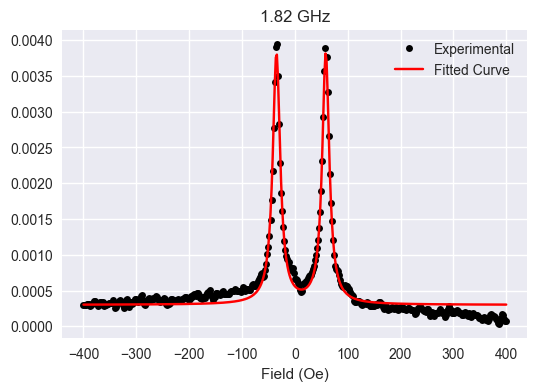

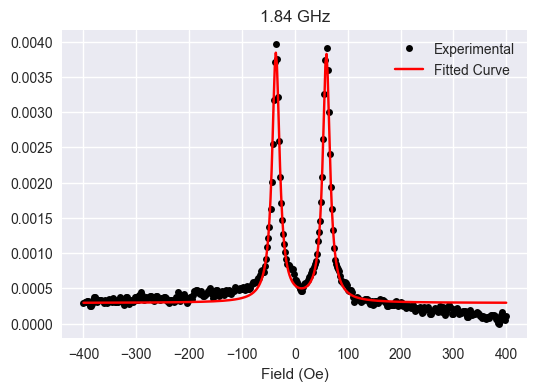

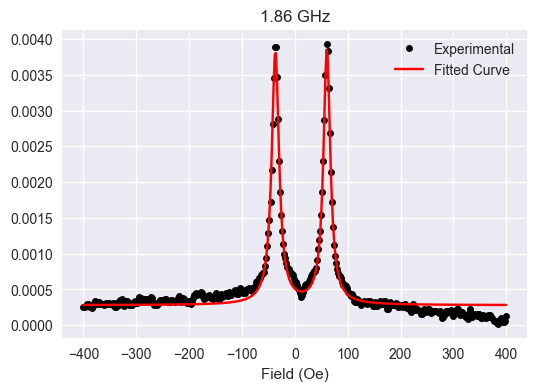

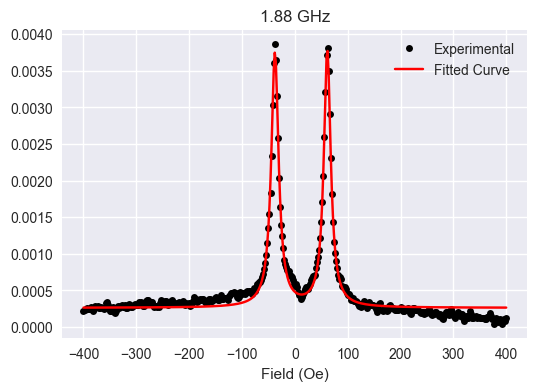

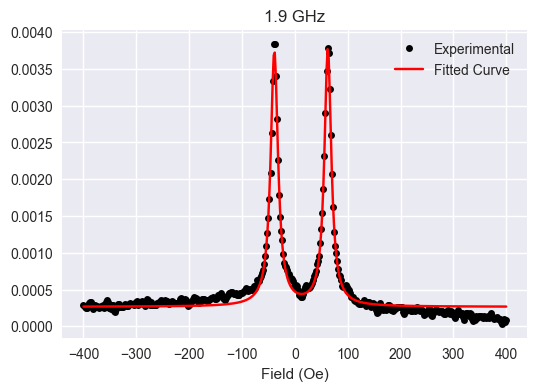

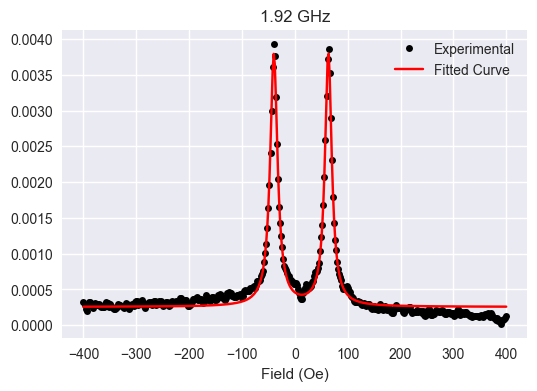

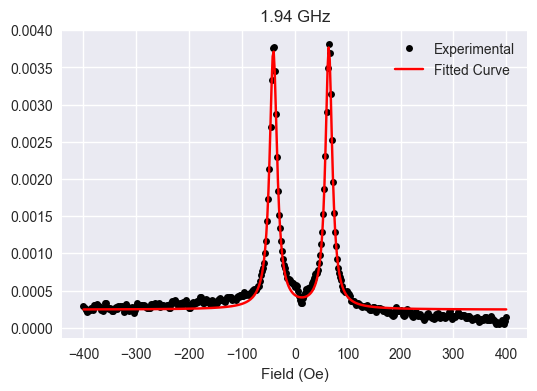

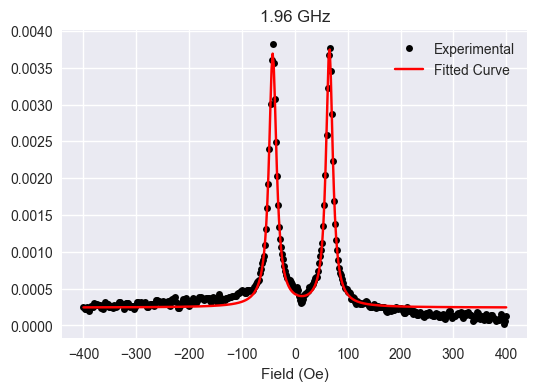

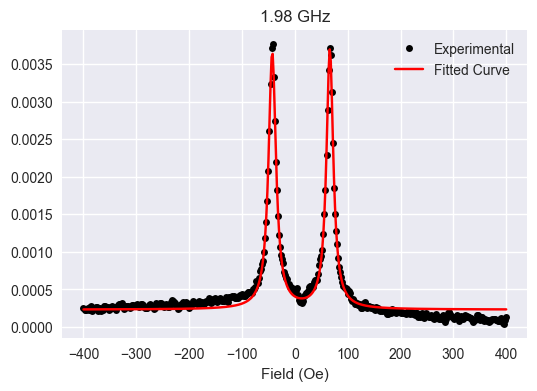

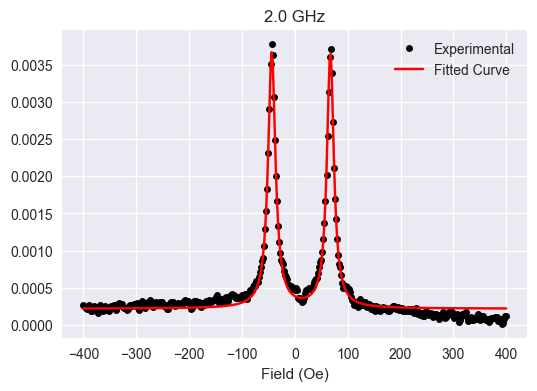

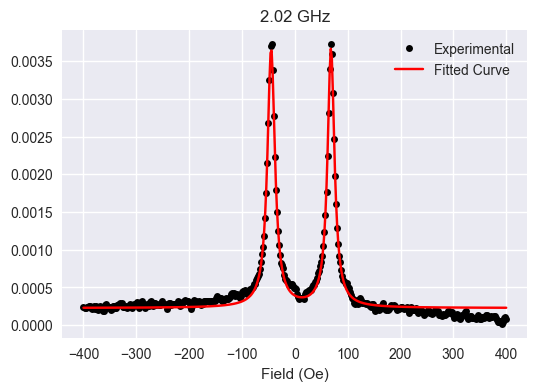

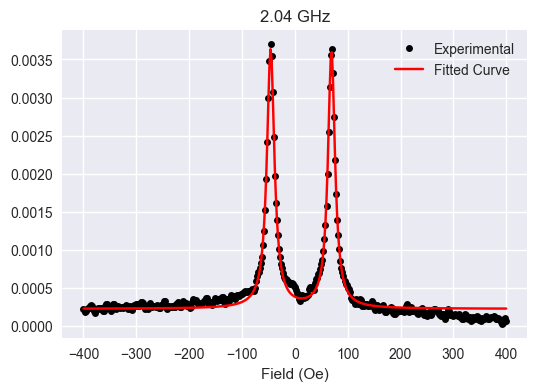

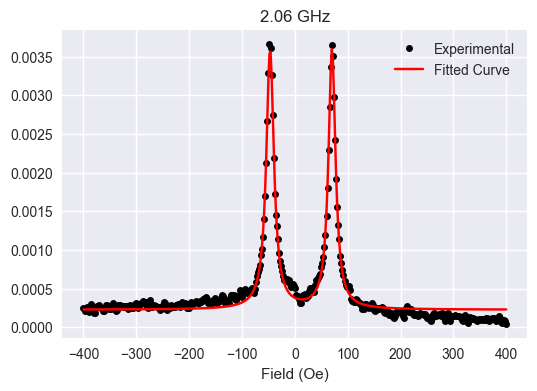

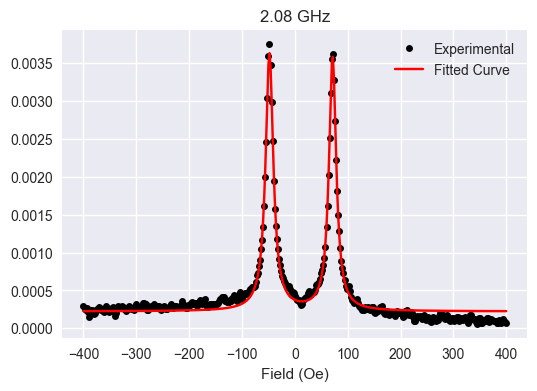

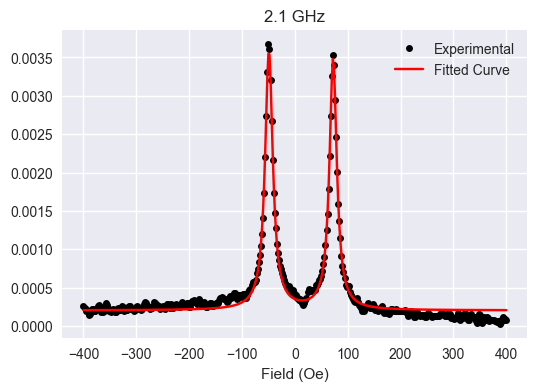

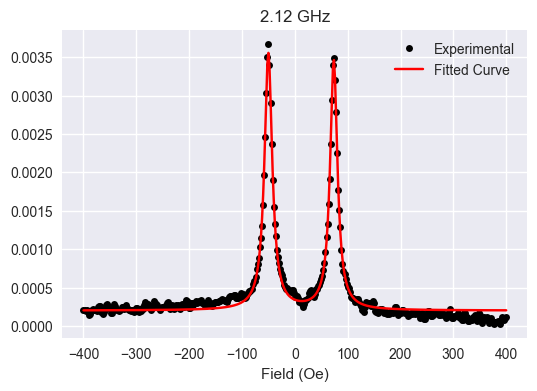

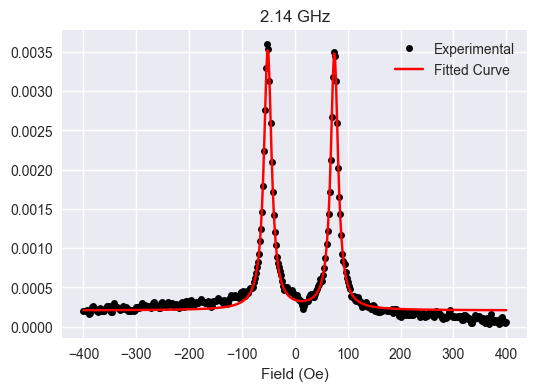

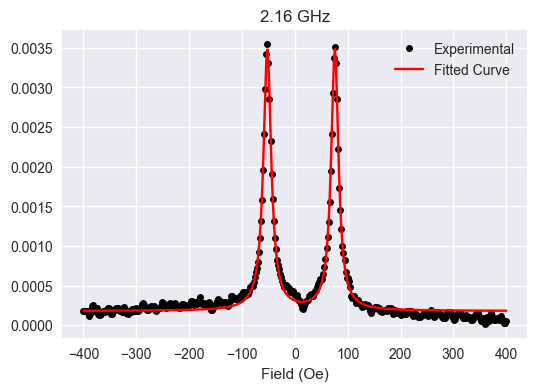

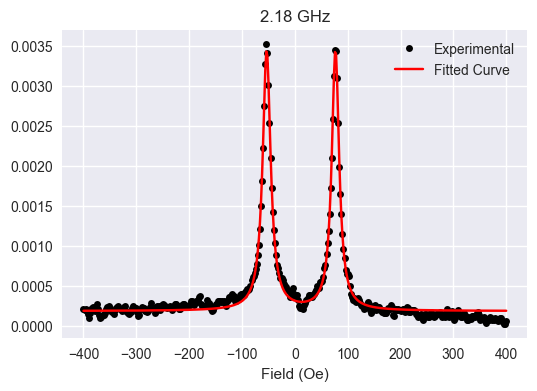

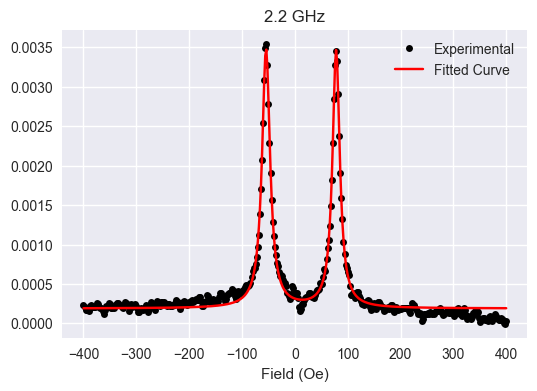

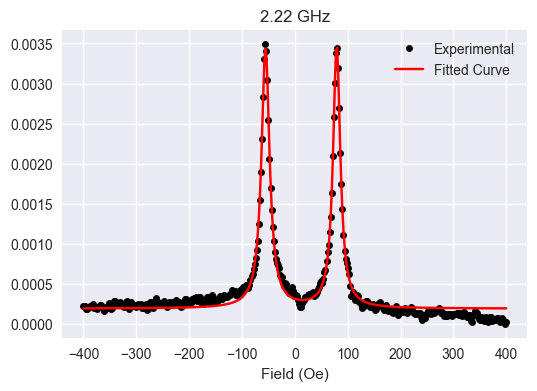

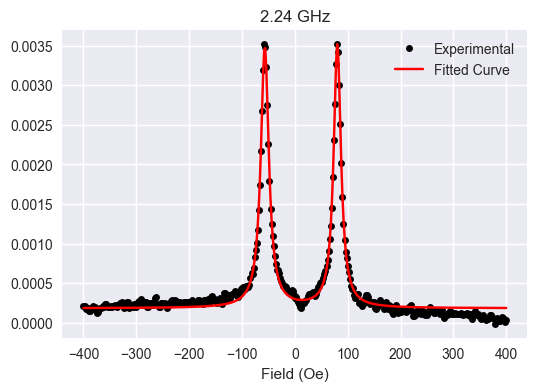

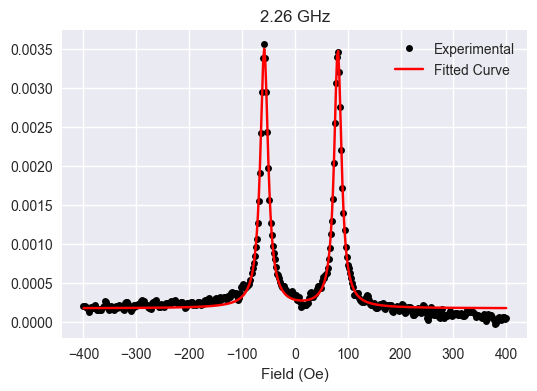

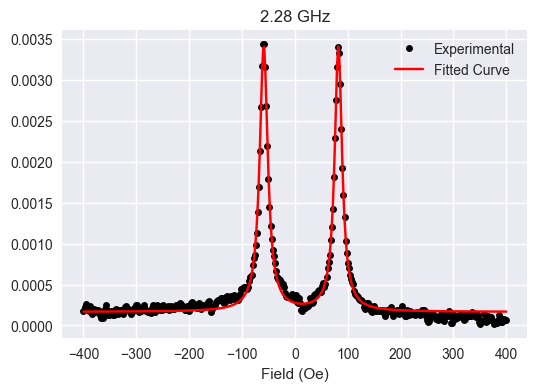

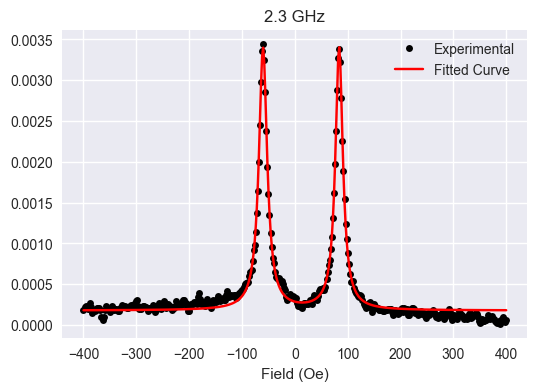

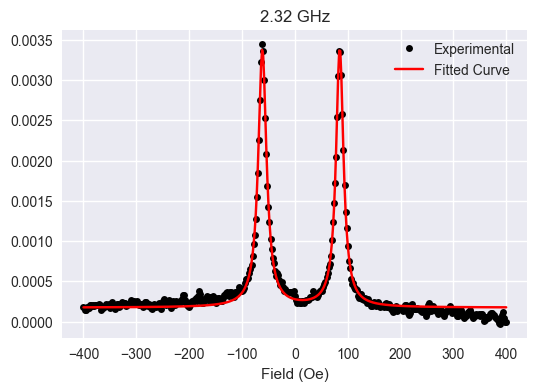

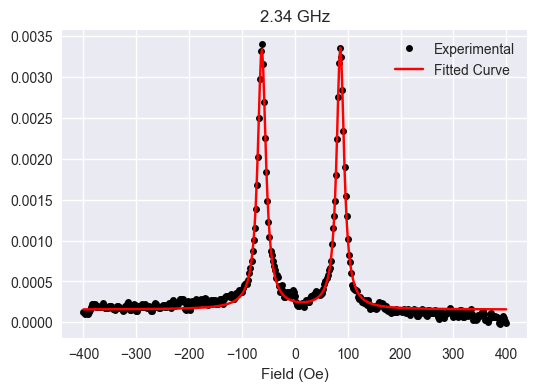

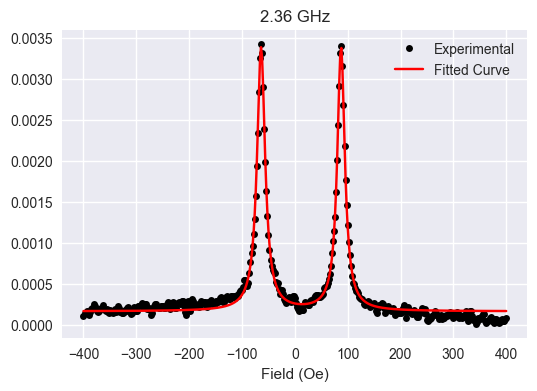

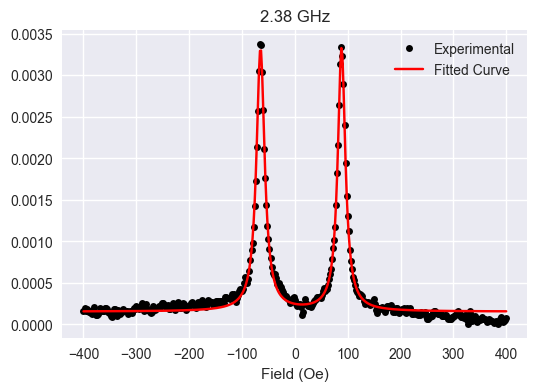

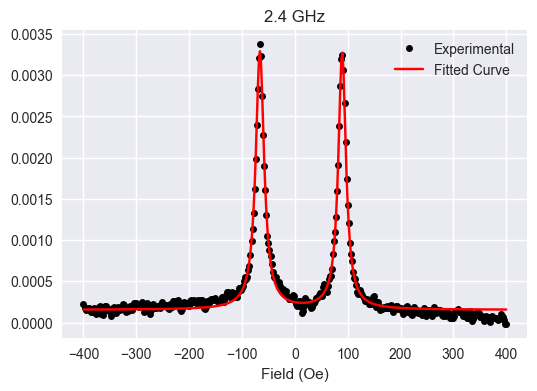

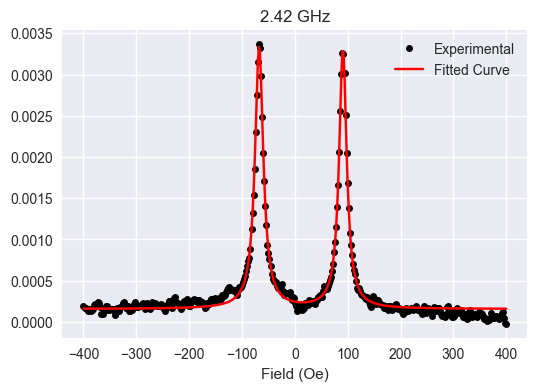

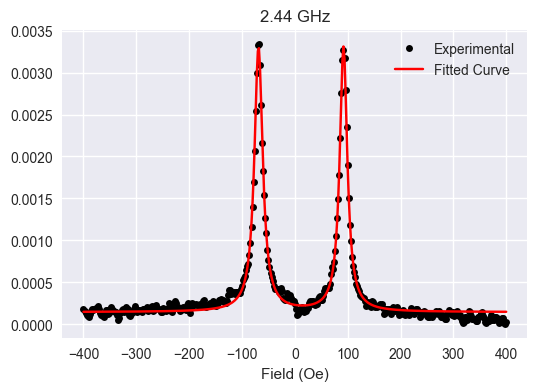

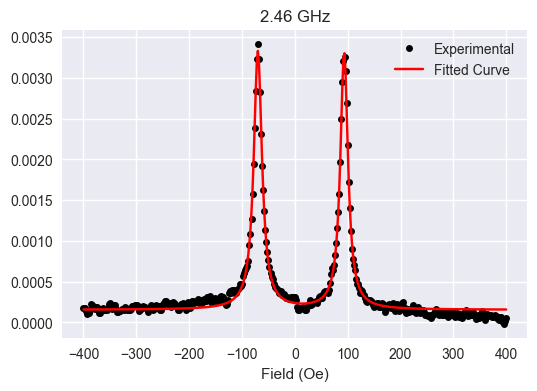

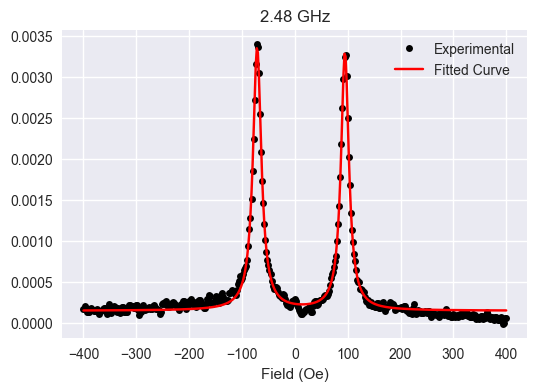

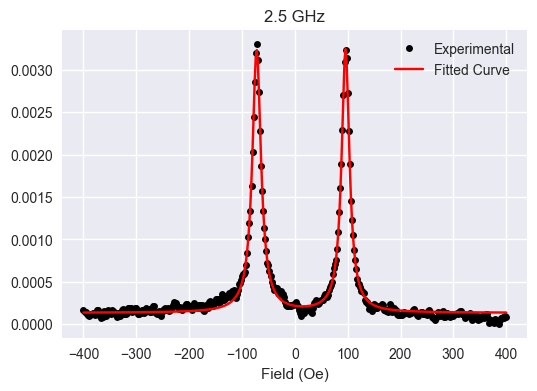

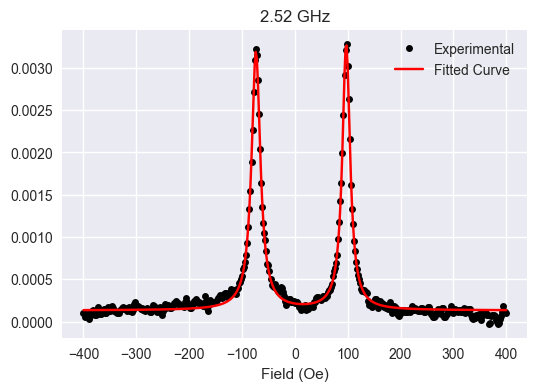

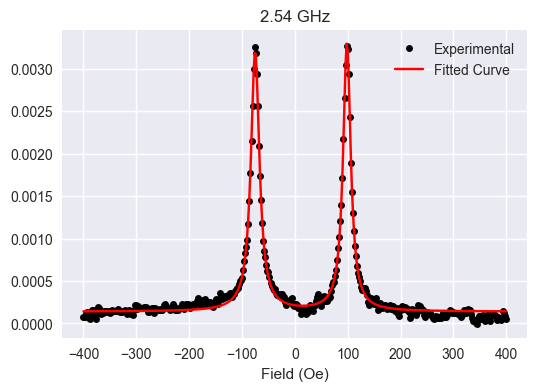

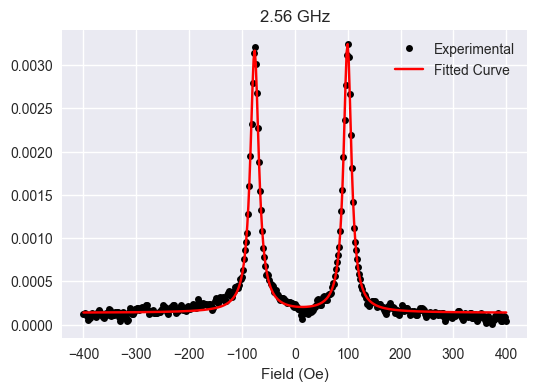

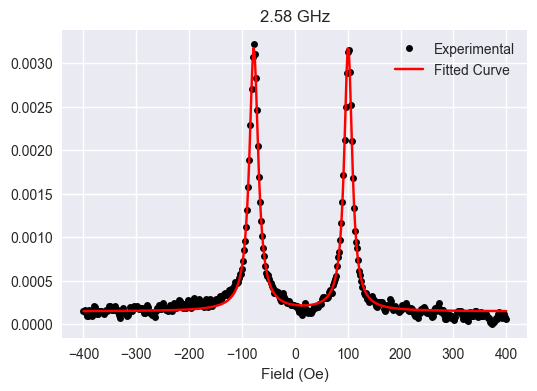

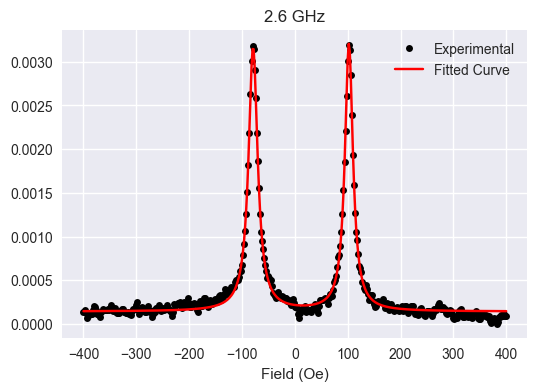

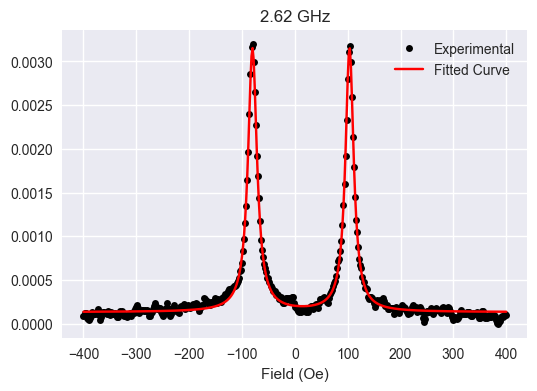

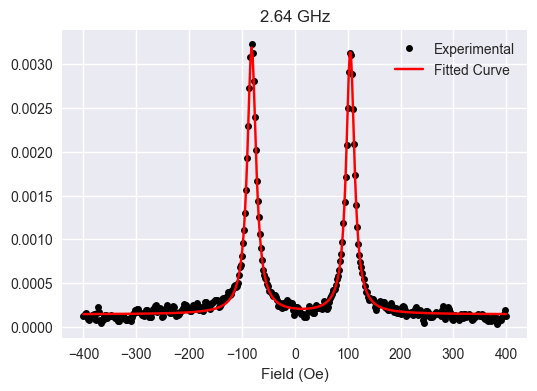

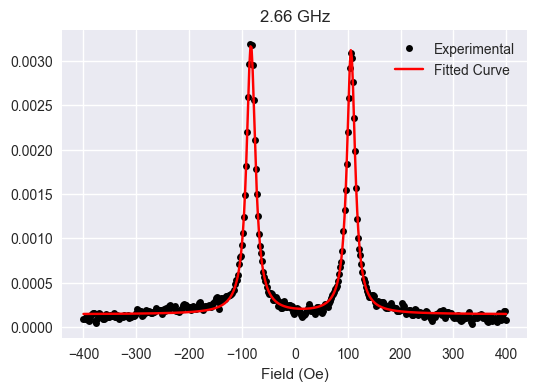

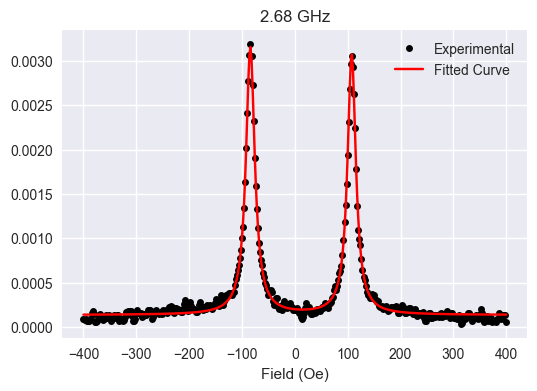

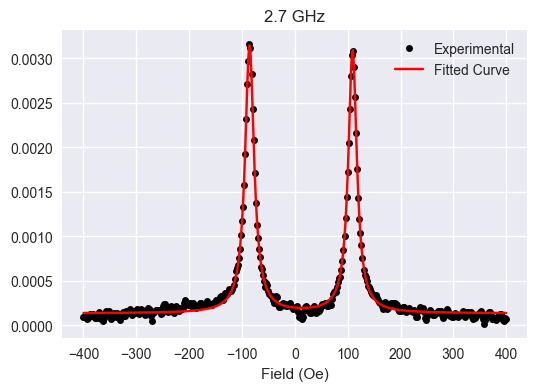

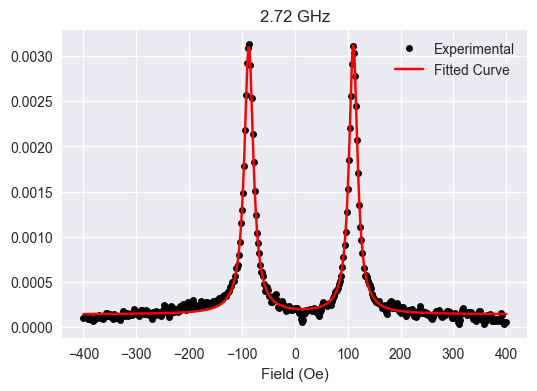

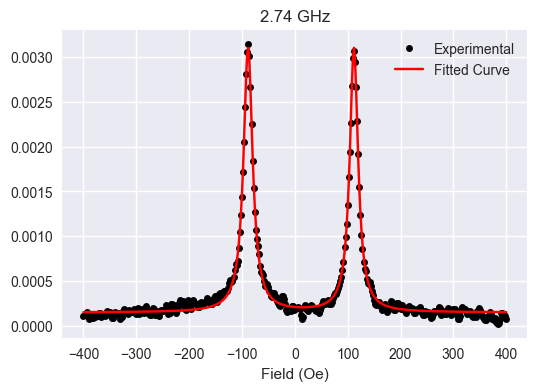

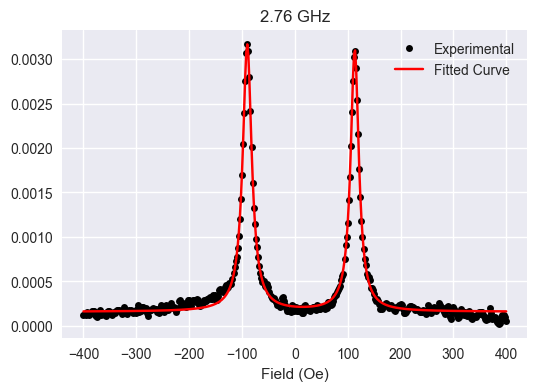

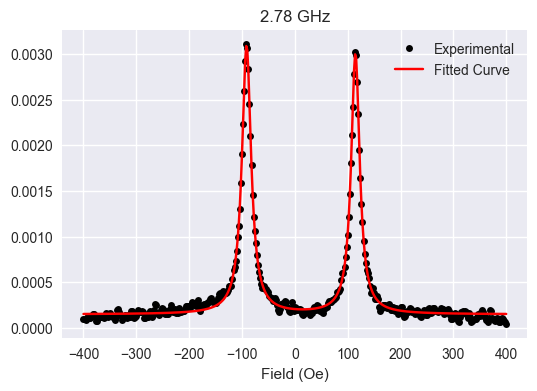

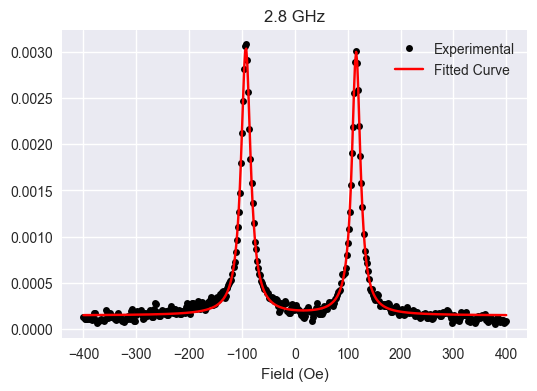

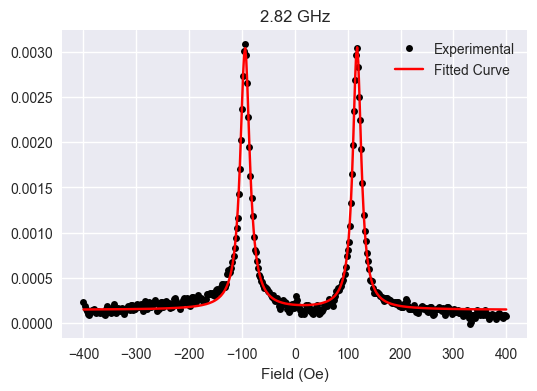

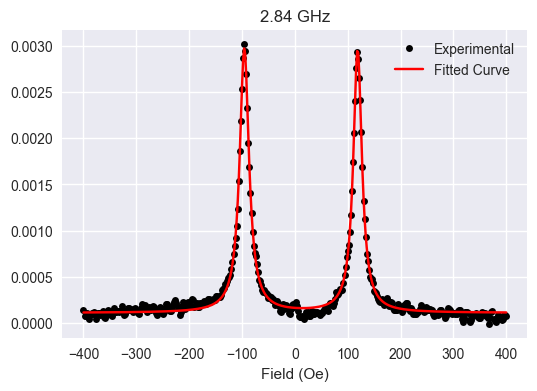

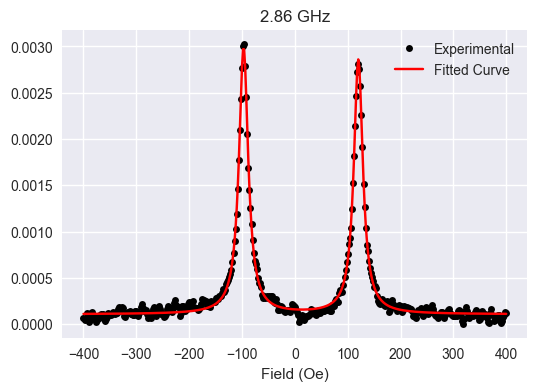

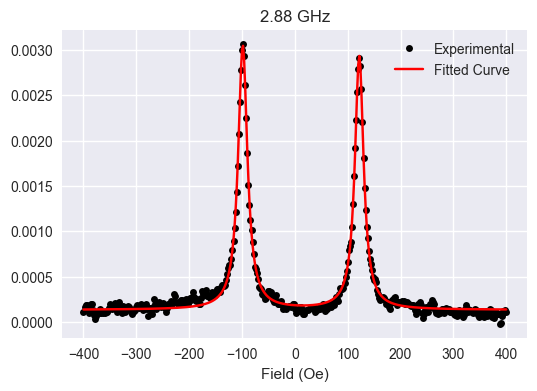

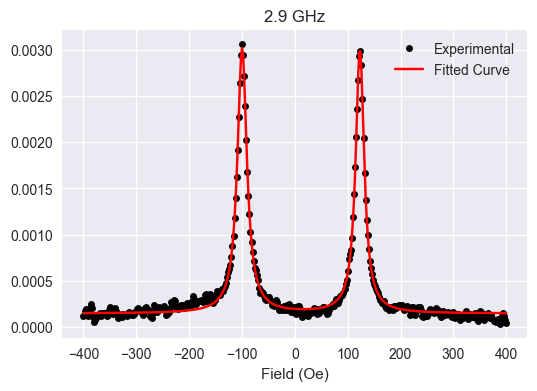

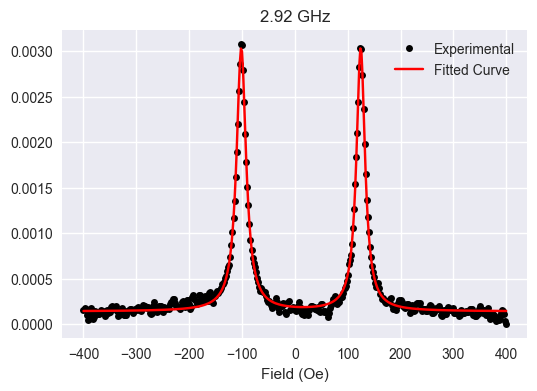

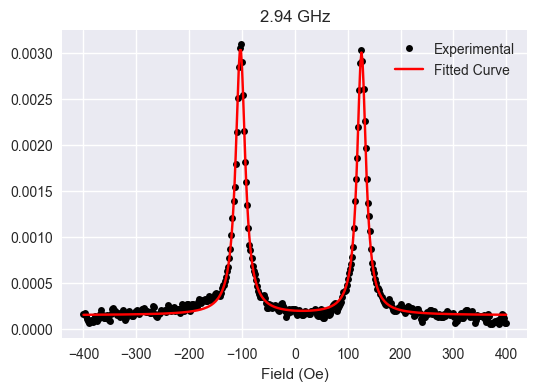

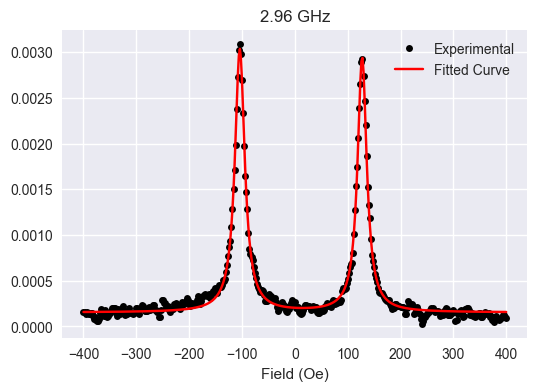

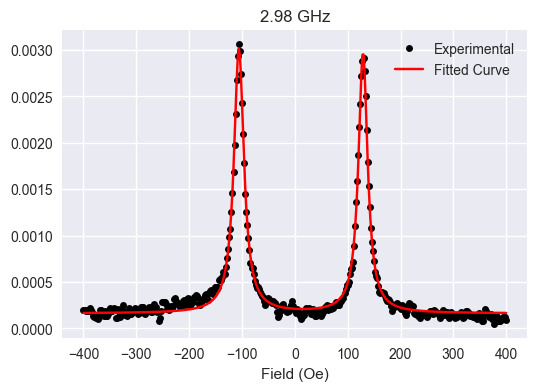

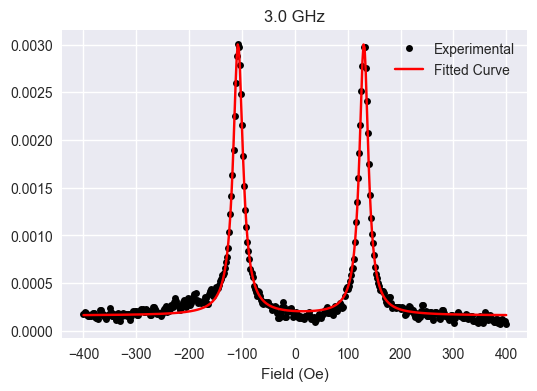

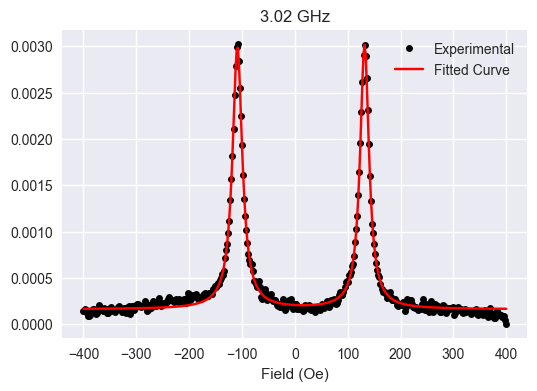

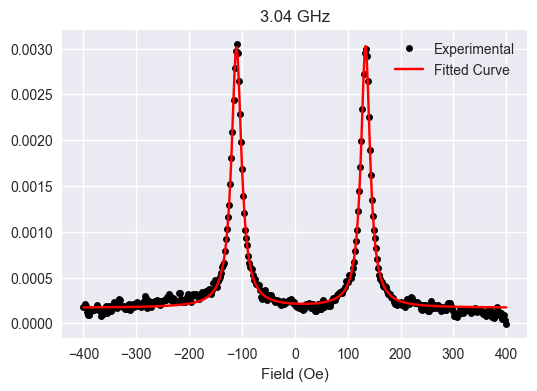

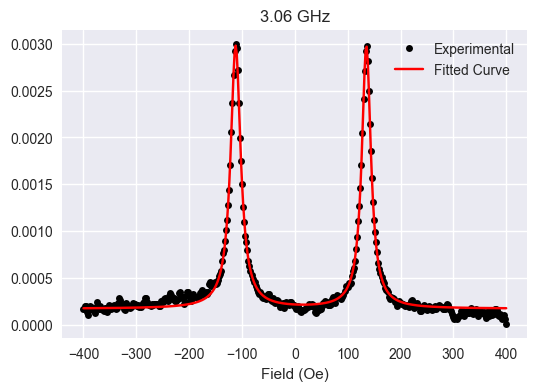

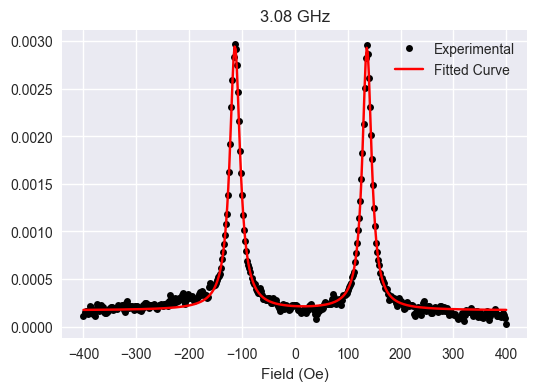

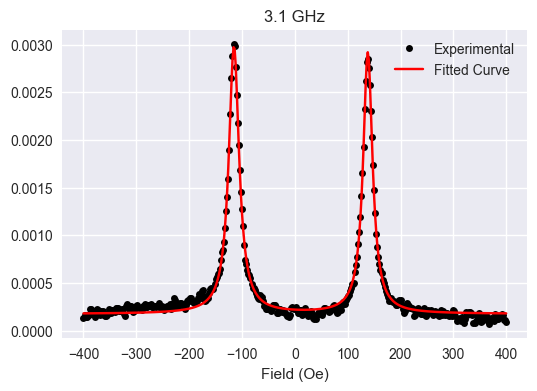

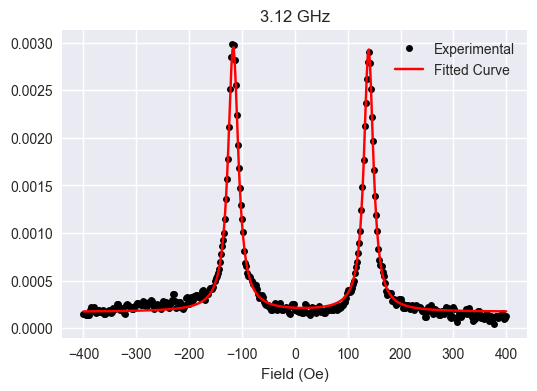

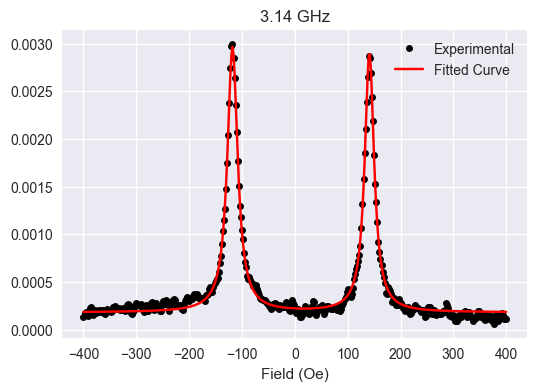

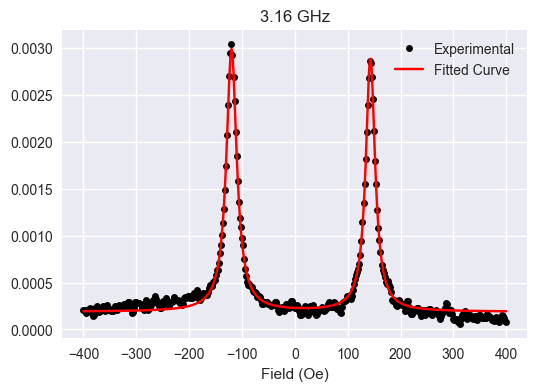

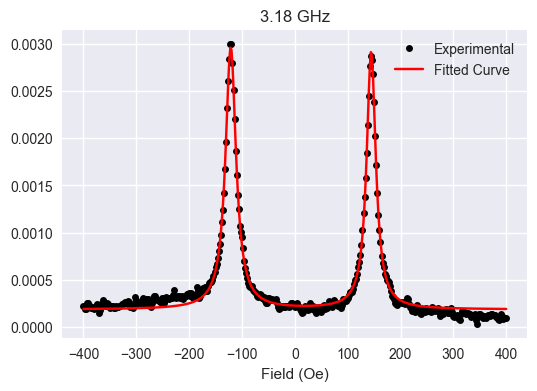

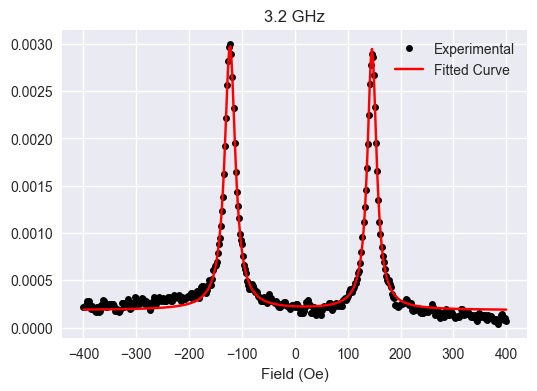

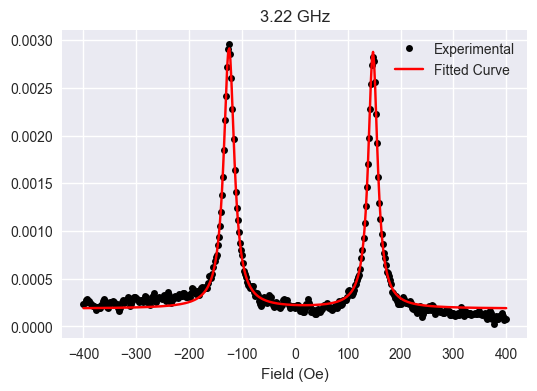

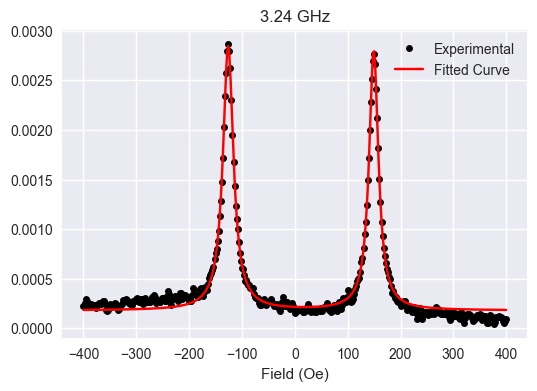

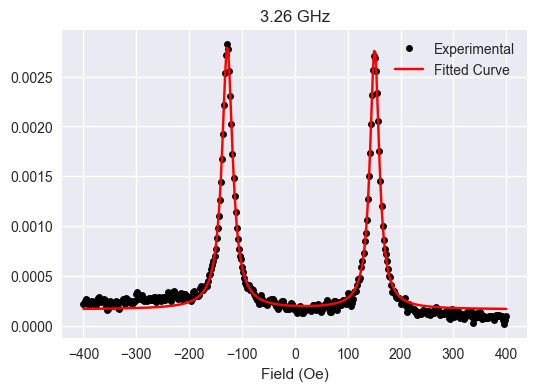

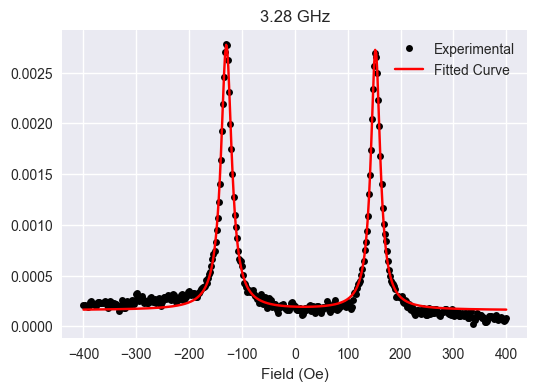

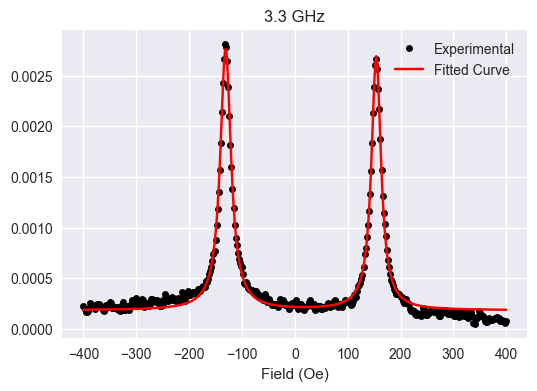

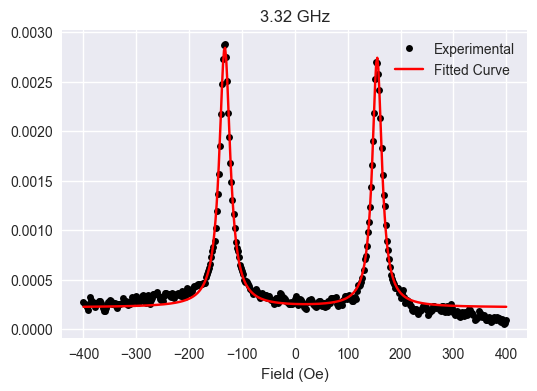

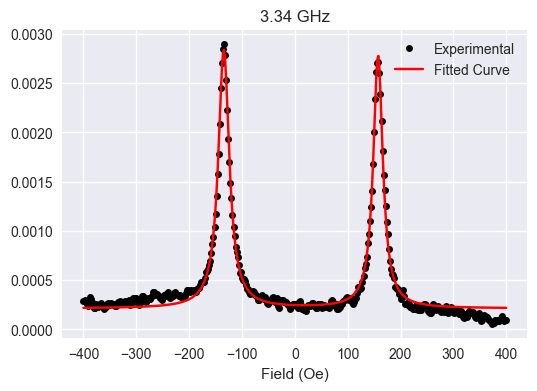

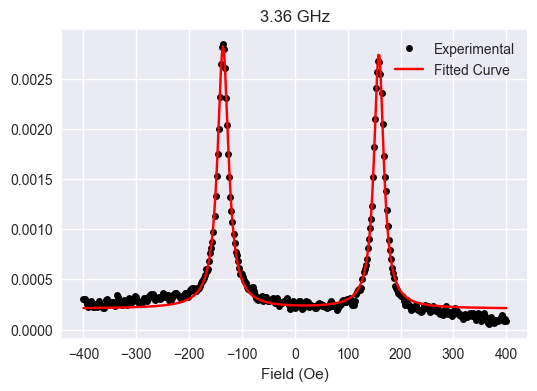

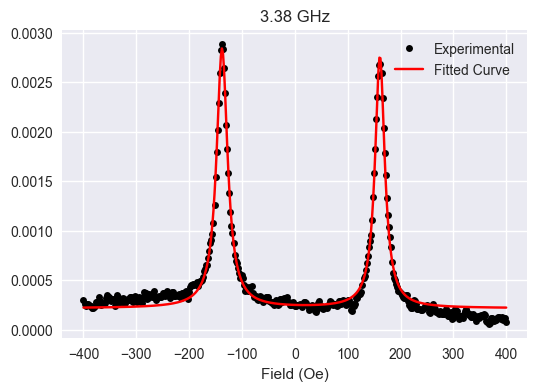

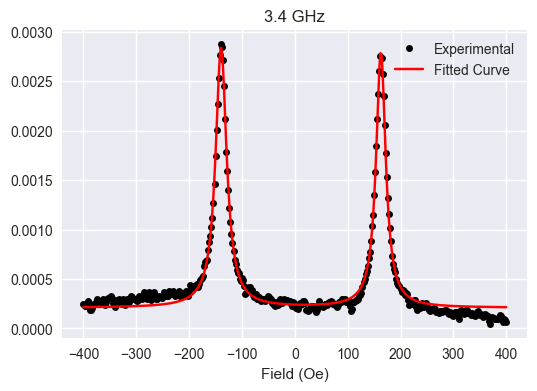

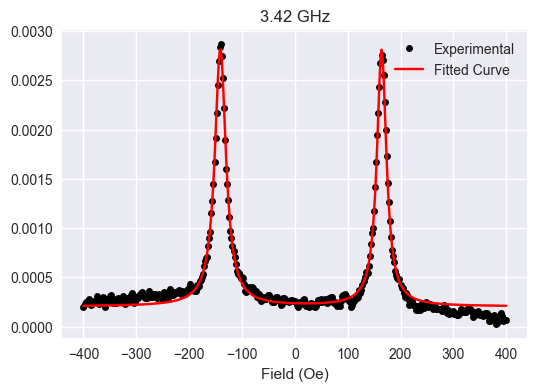

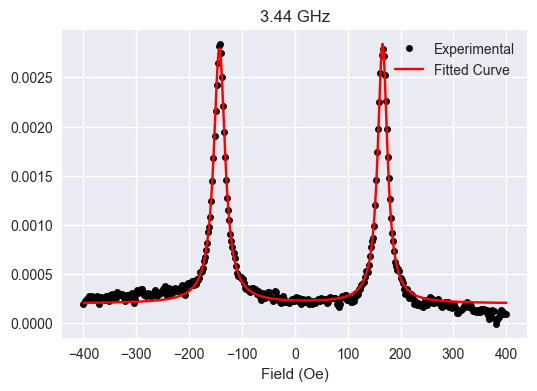

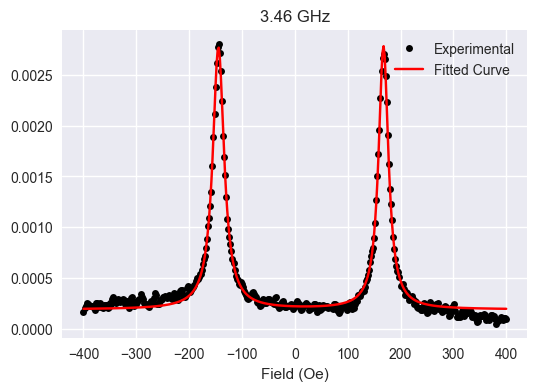

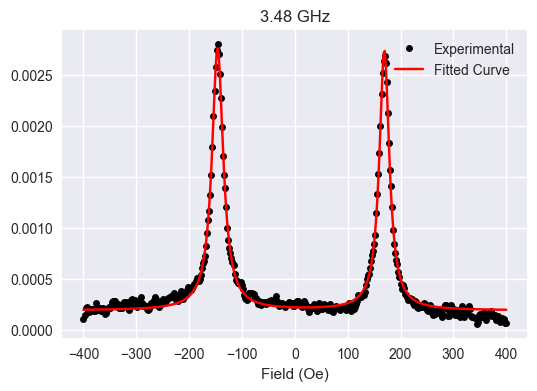

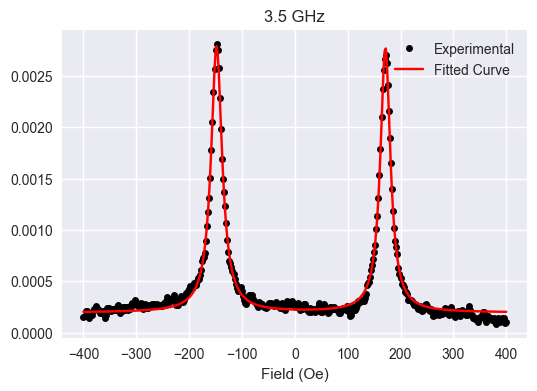

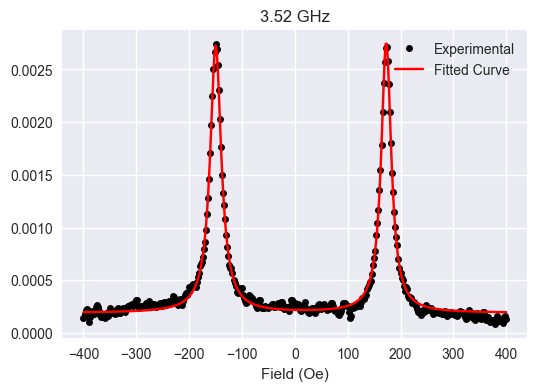

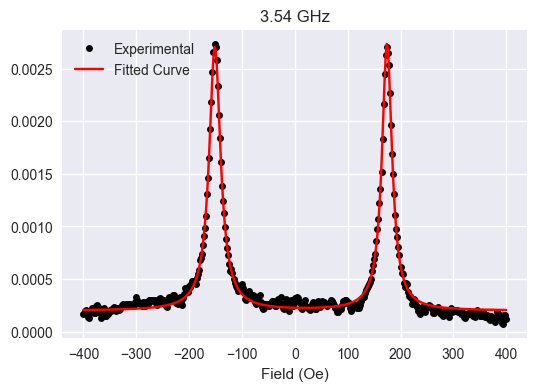

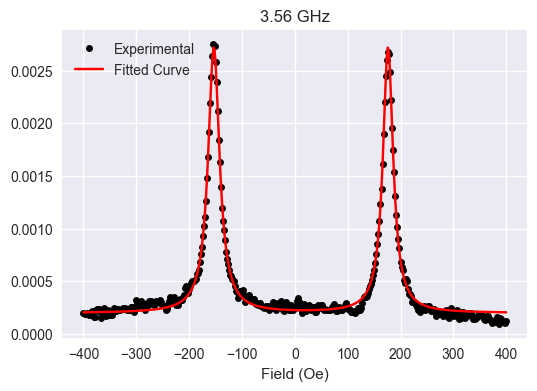

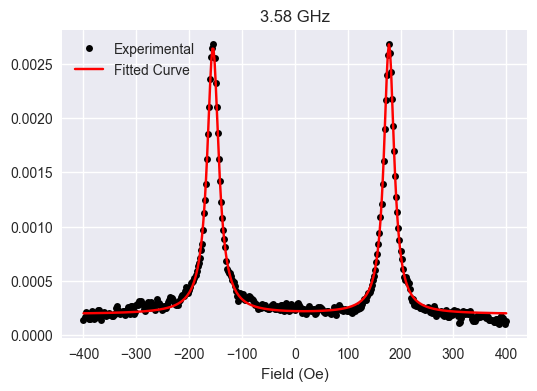

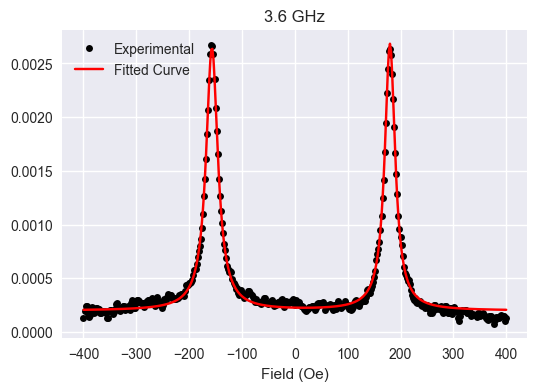

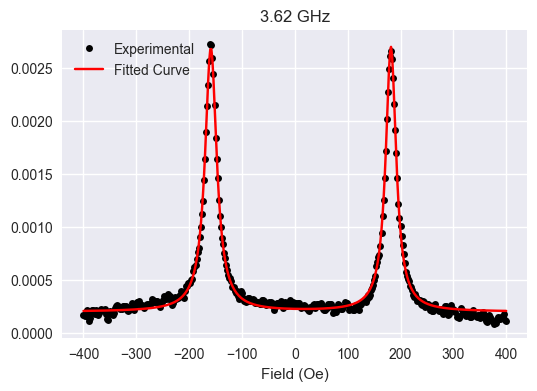

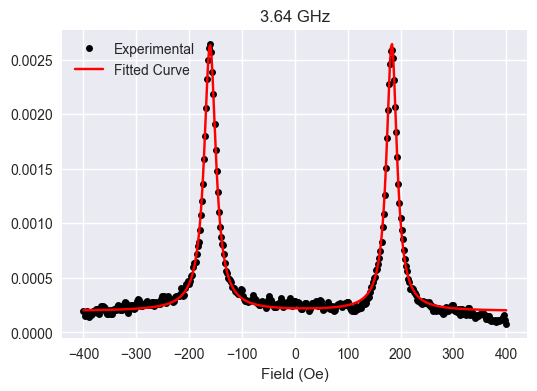

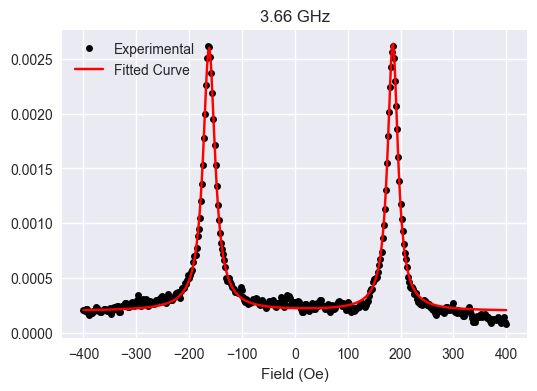

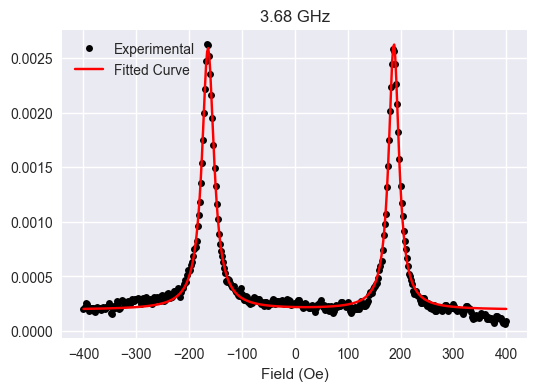

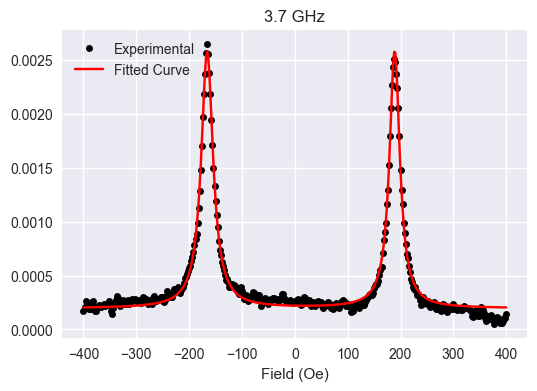

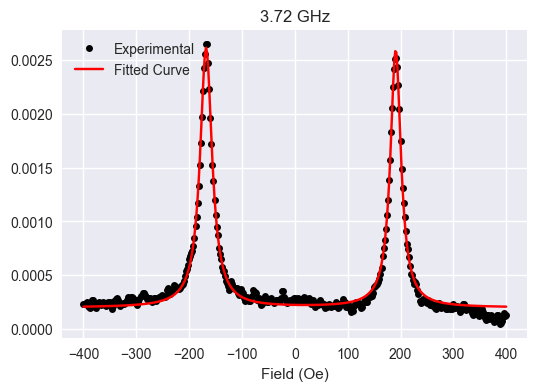

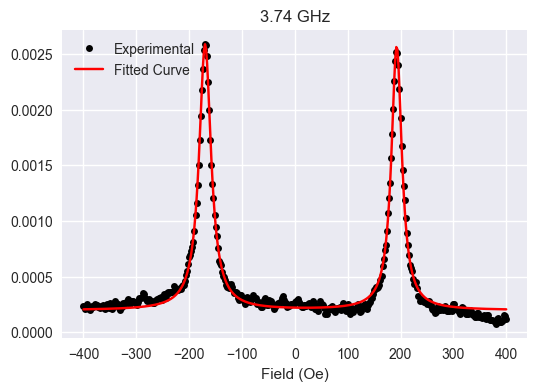

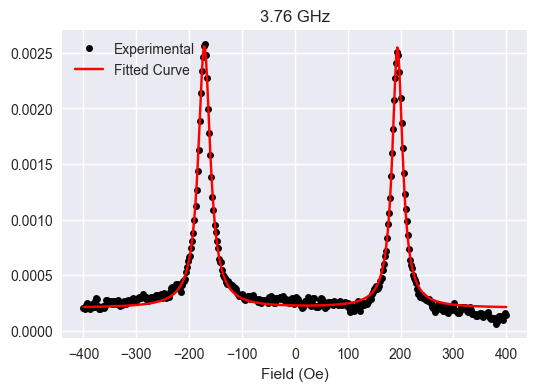

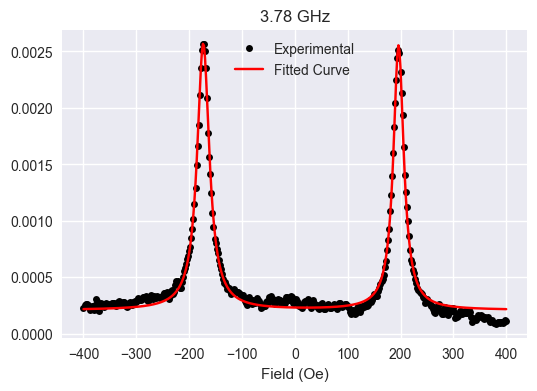

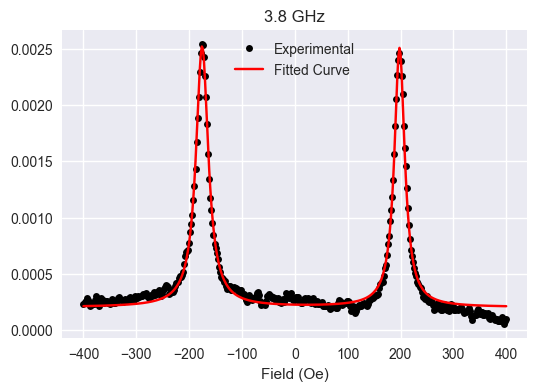

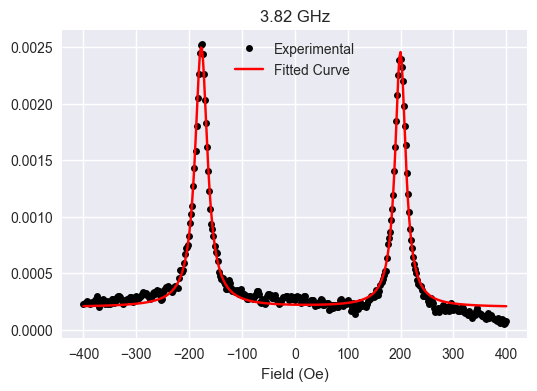

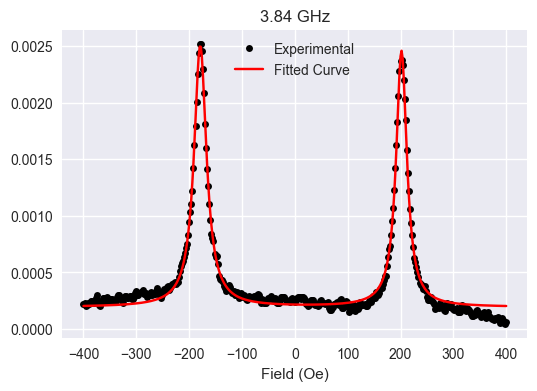

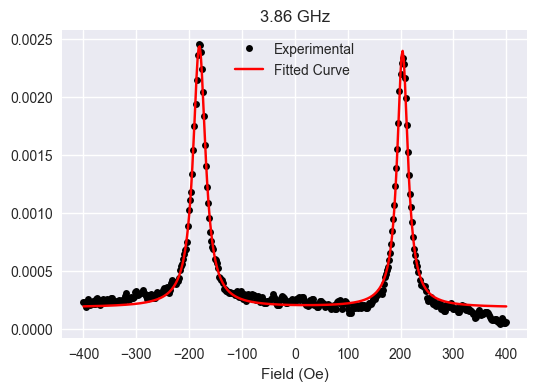

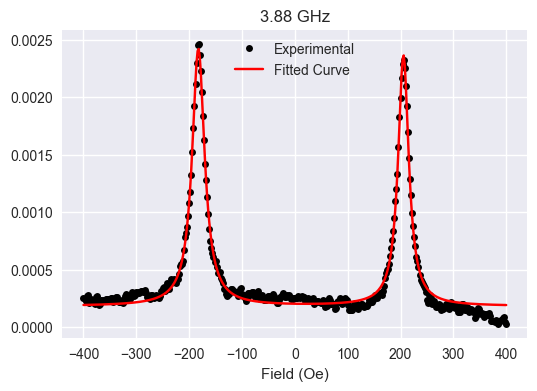

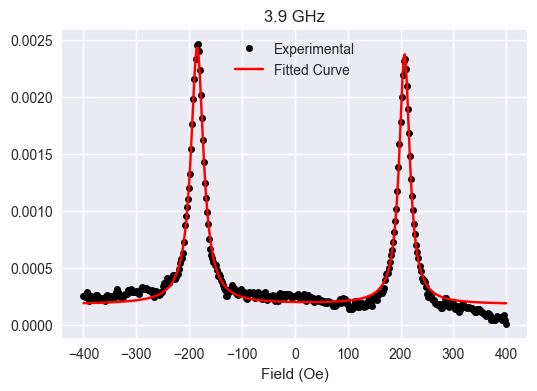

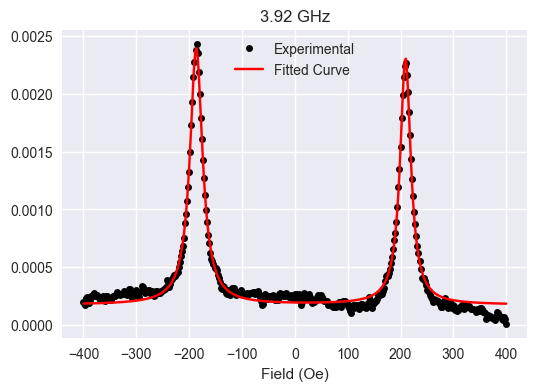

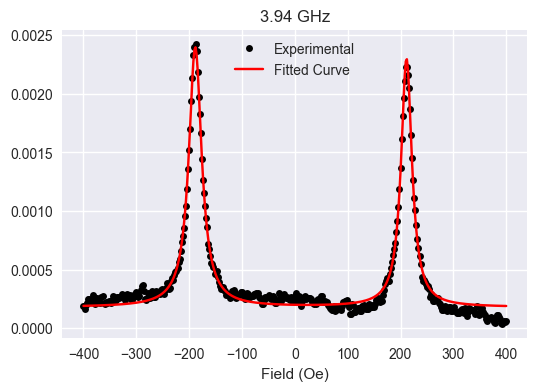

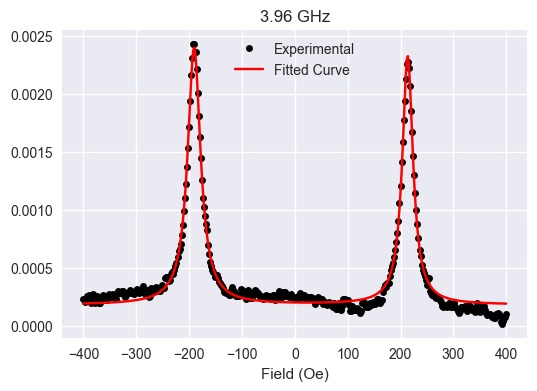

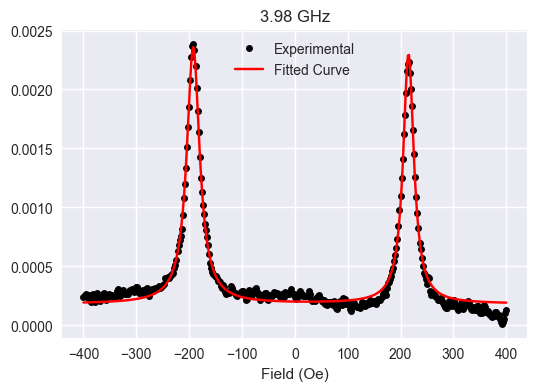

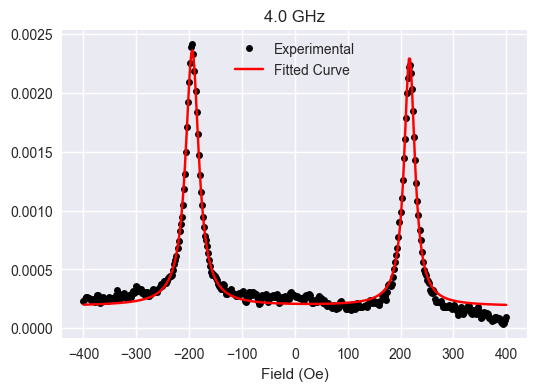

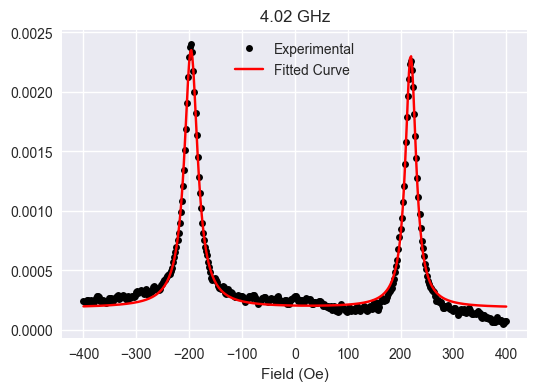

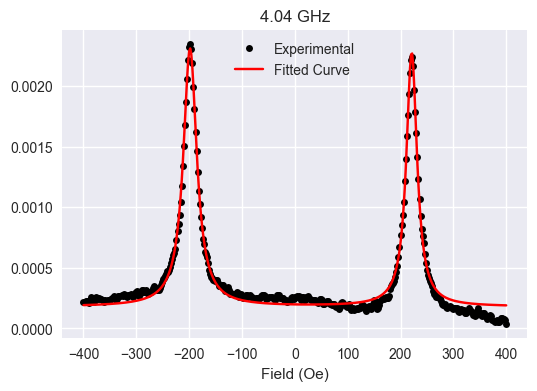

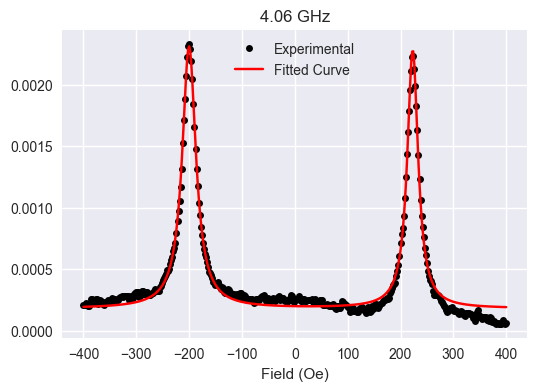

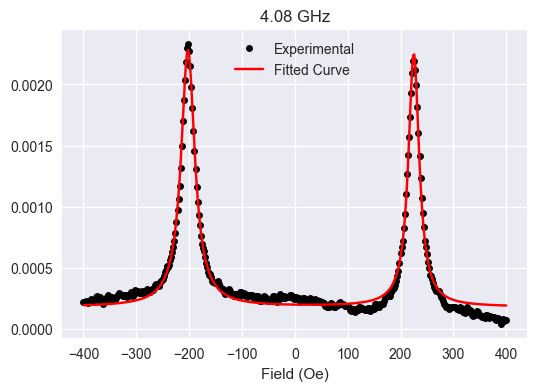

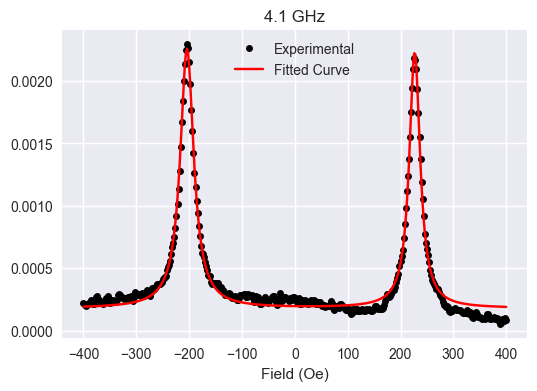

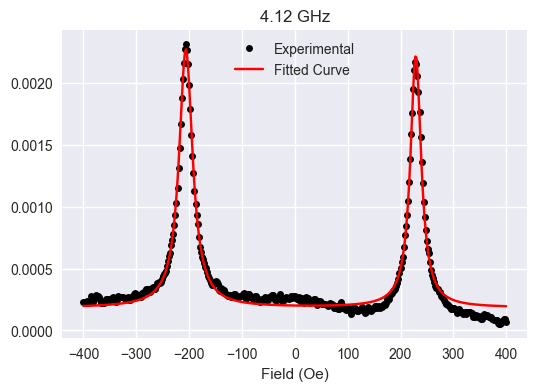

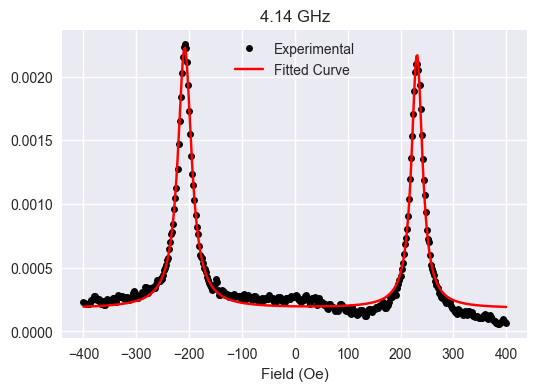

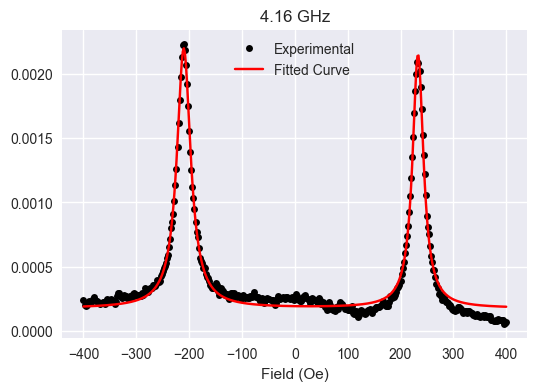

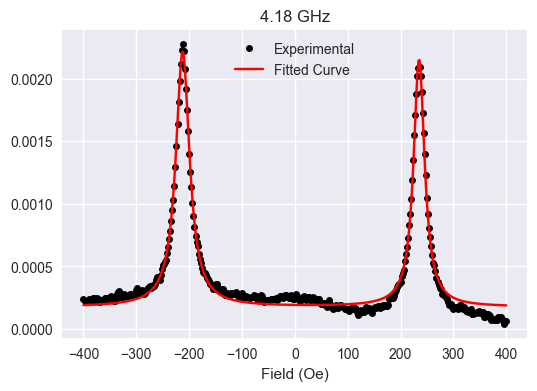

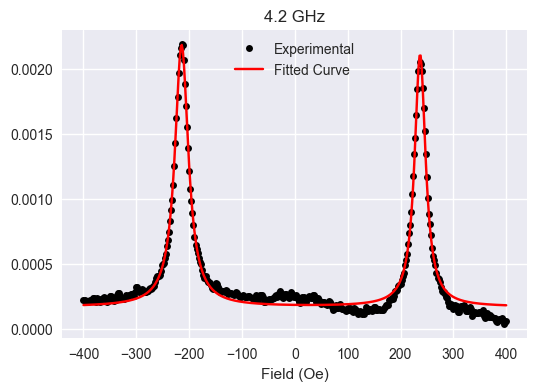

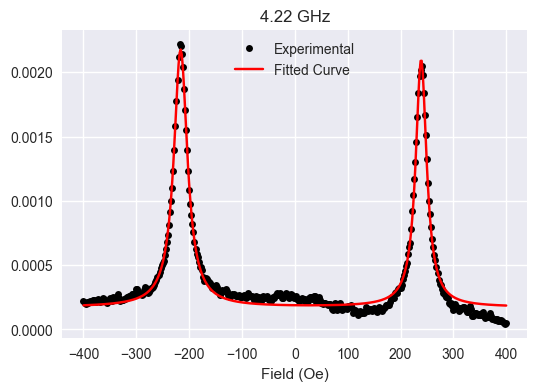

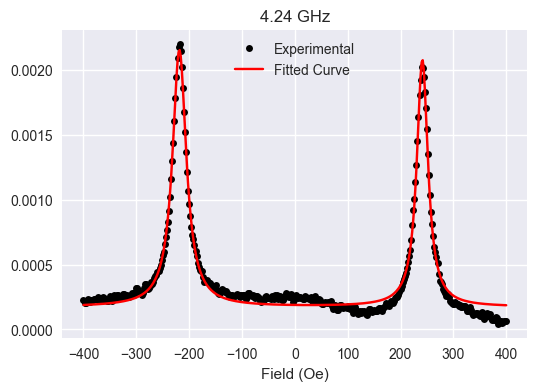

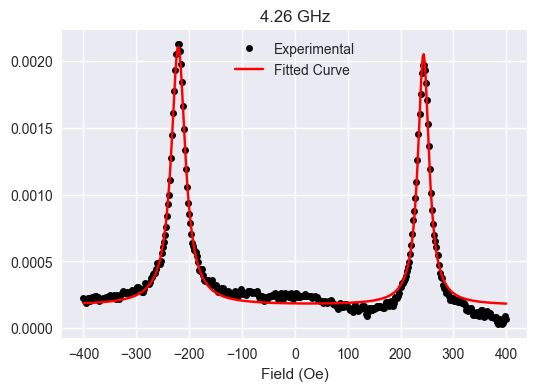

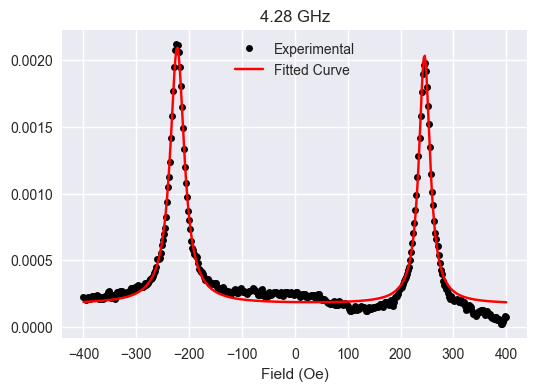

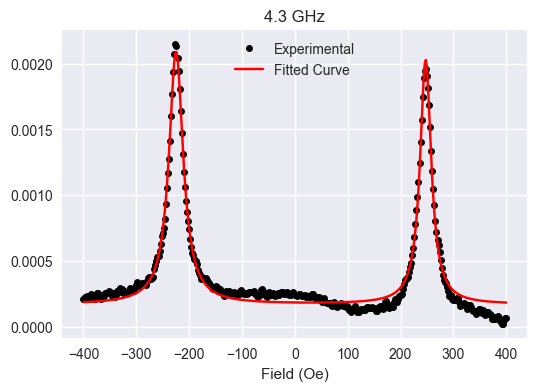

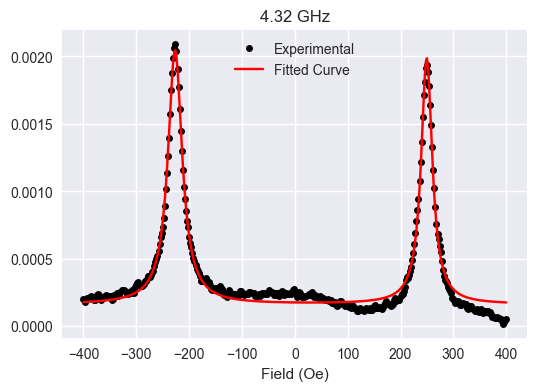

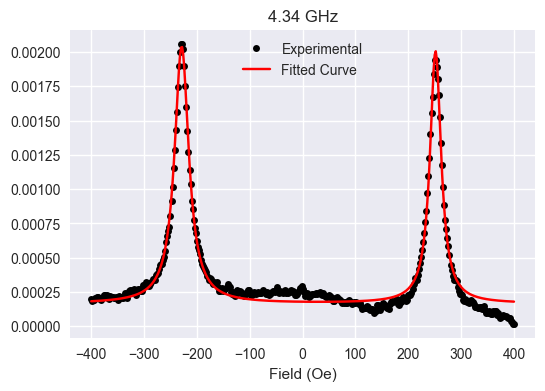

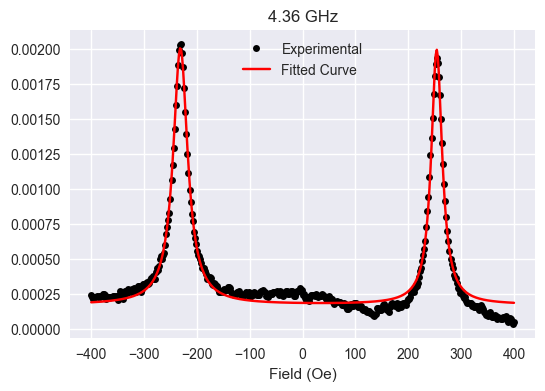

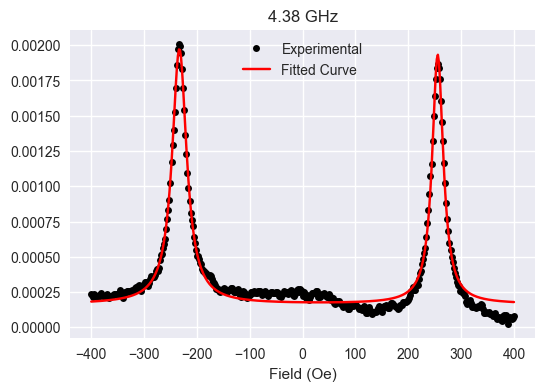

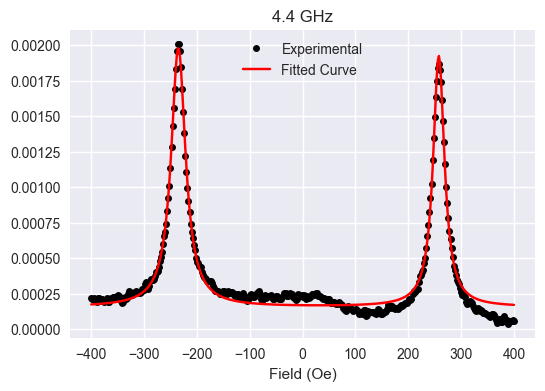

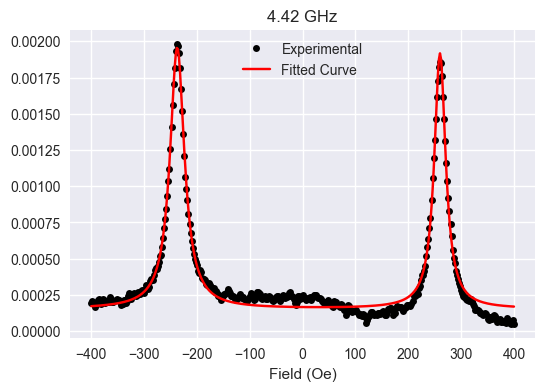

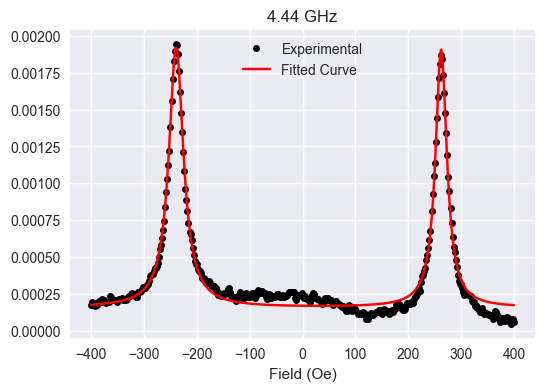

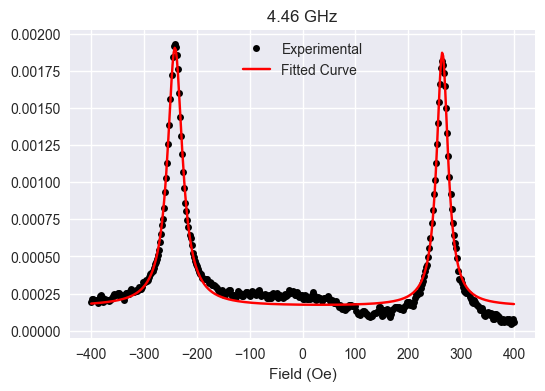

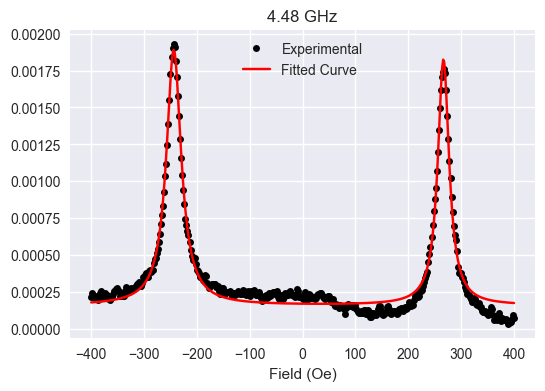

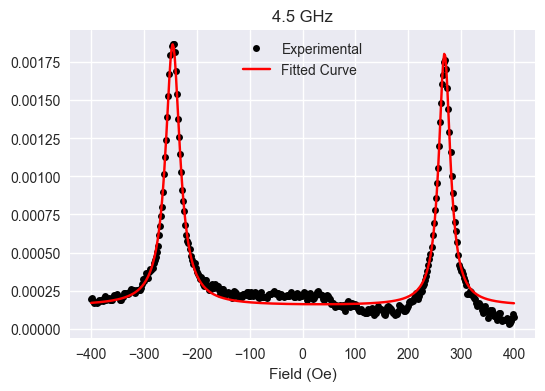

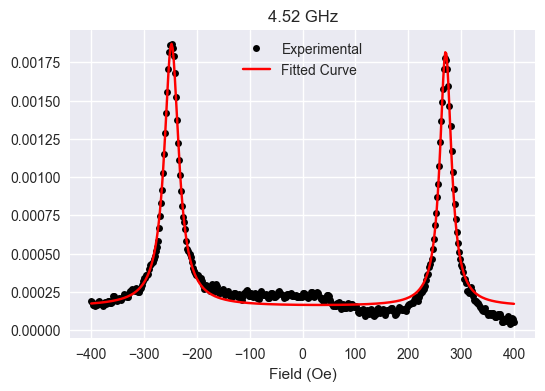

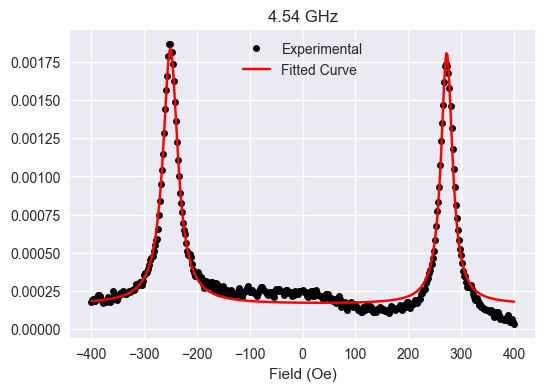

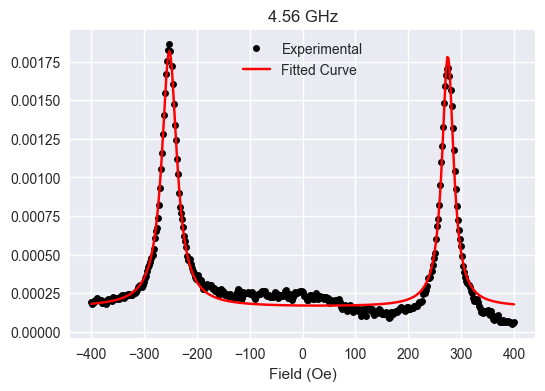

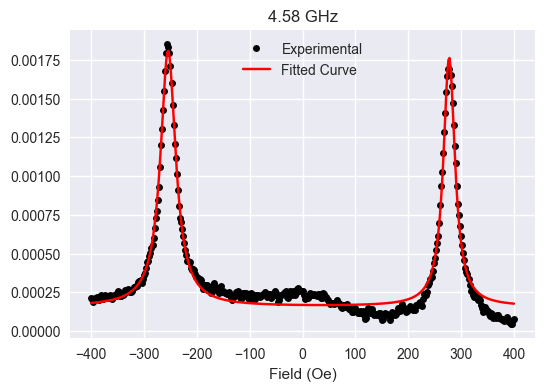

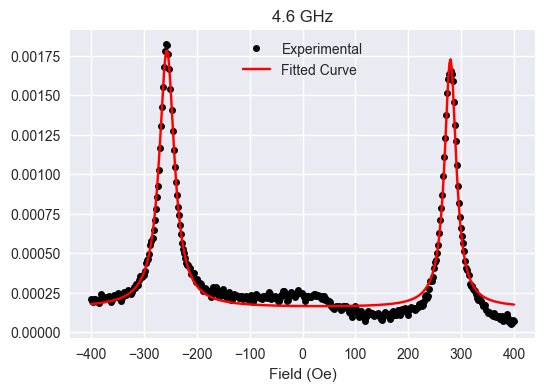

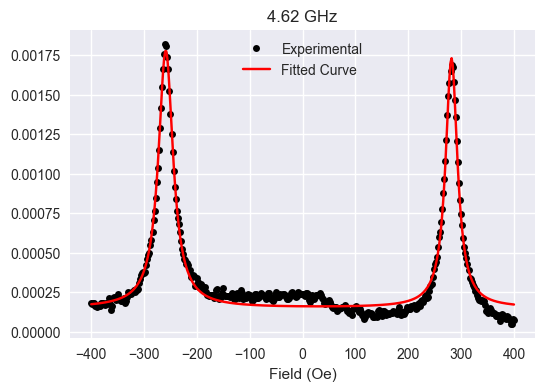

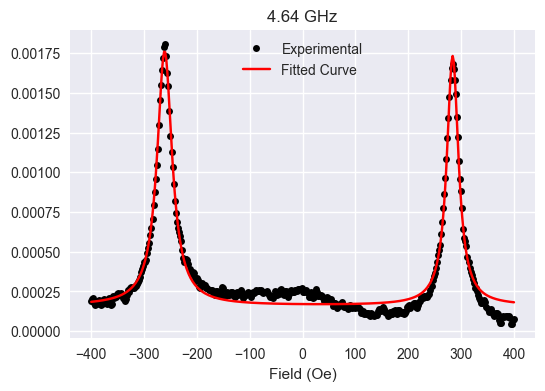

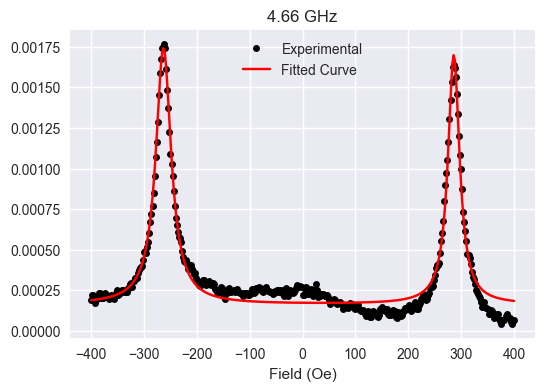

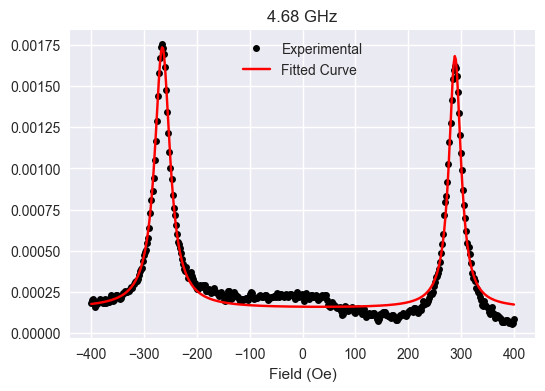

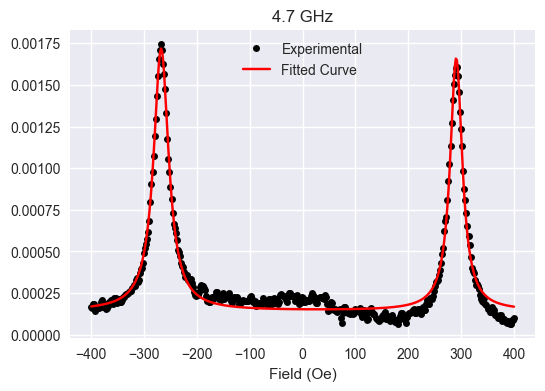

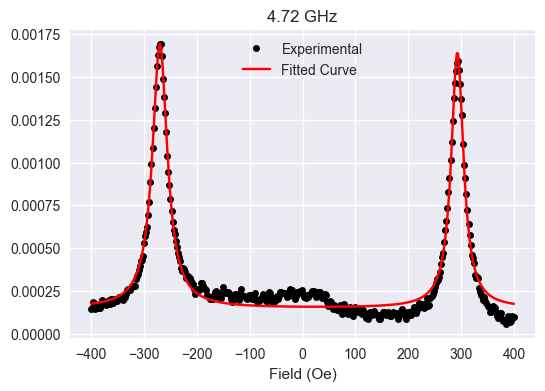

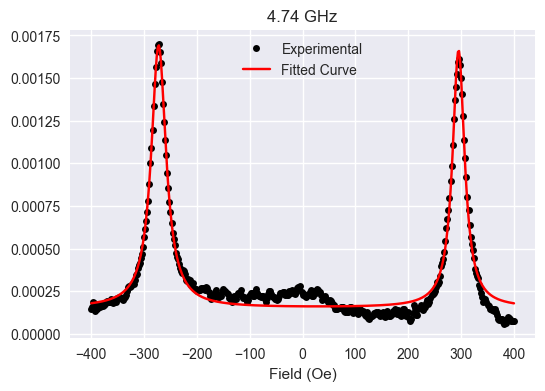

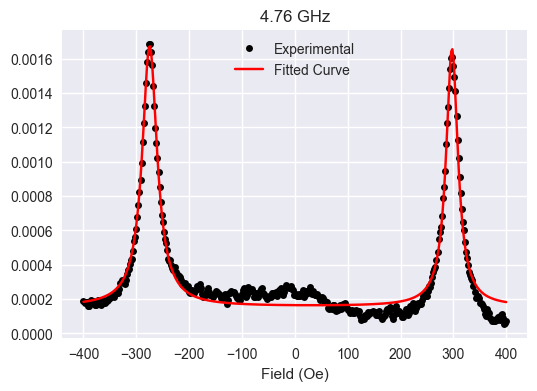

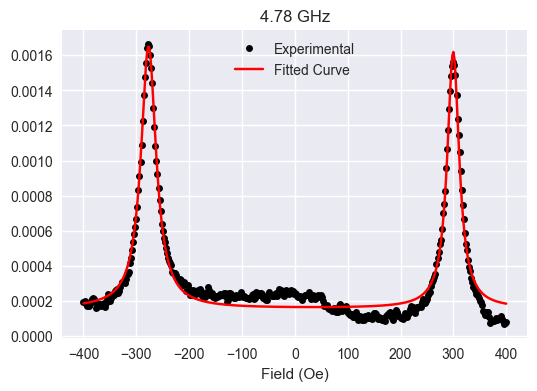

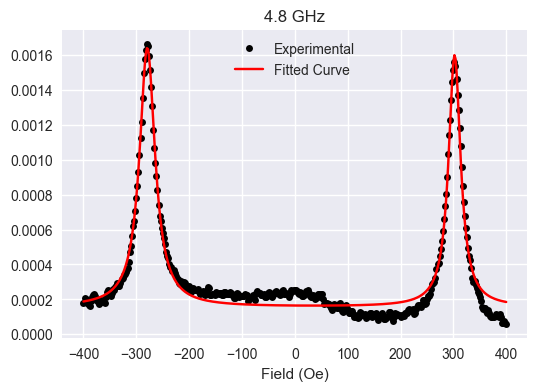

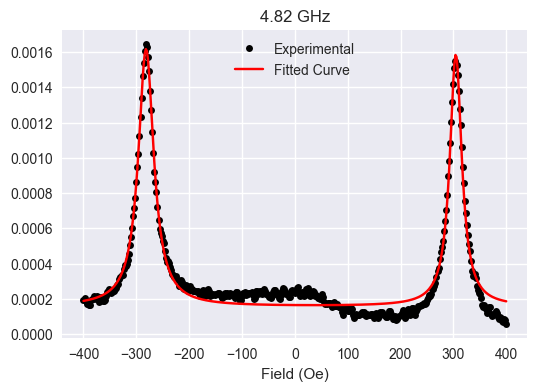

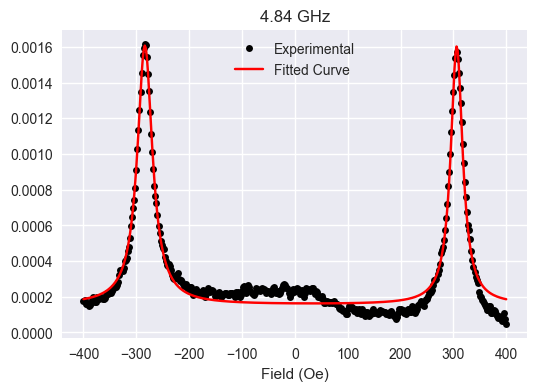

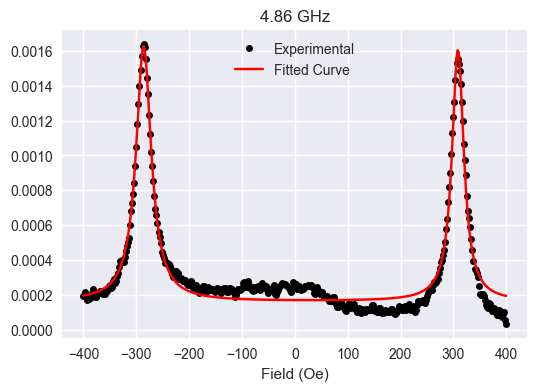

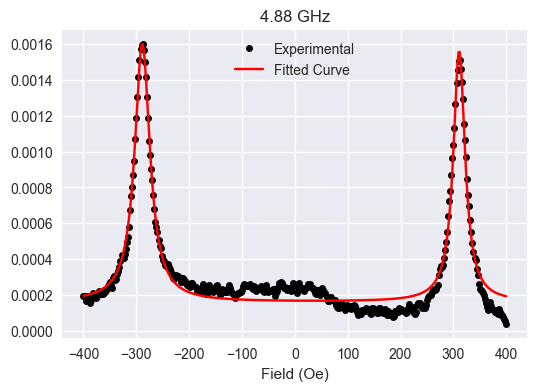

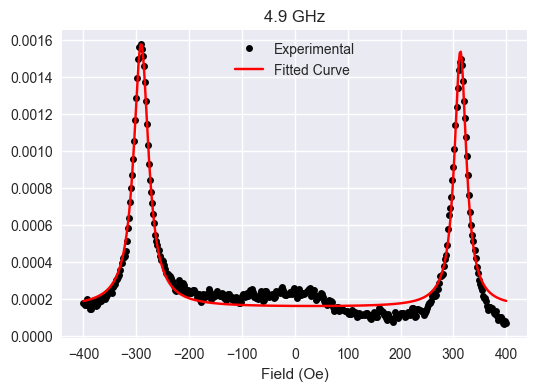

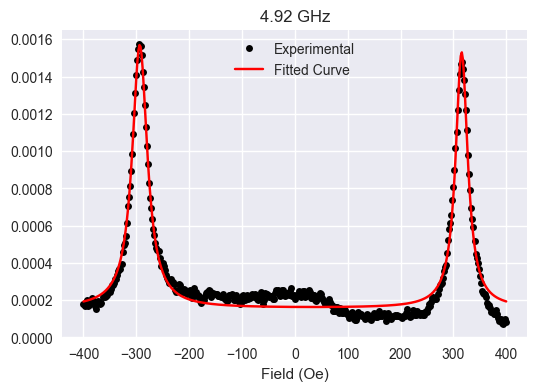

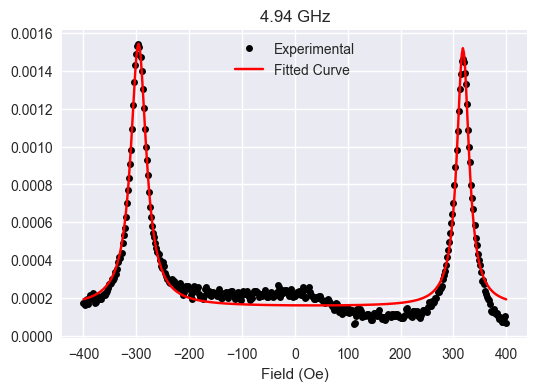

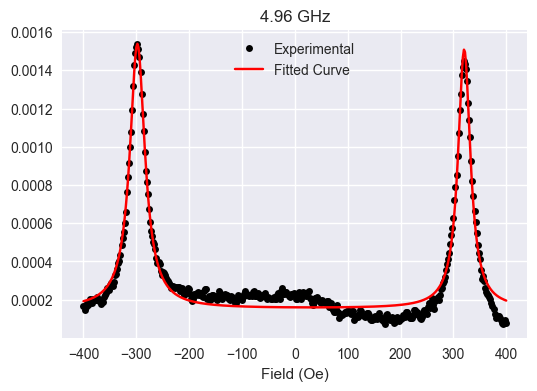

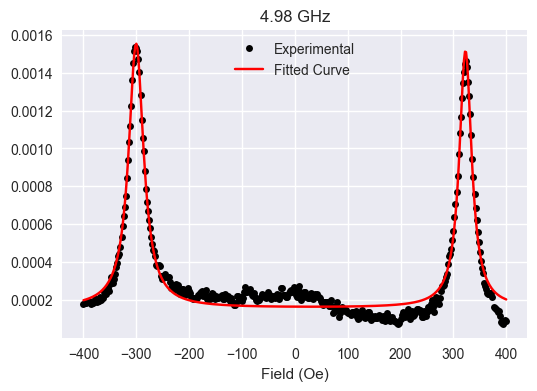

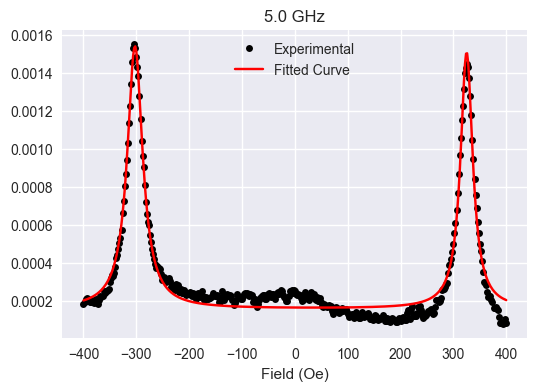

In [12]:
# Create a unique file name based on the date and frequency range
sample = 'NiFe_test'
file_name = f'1Port {sample} Fitting_{freq_used.min()}-{freq_used.max()} GHz'
filepath = os.path.join(r'C:\Users\plyslab\Desktop\VNA Automation\Fittings', f'{file_name}.csv')

Fitting.lorentzian(freq_used, field_used, cutData, filepath, plotting=True)

### Spectrum Visualization

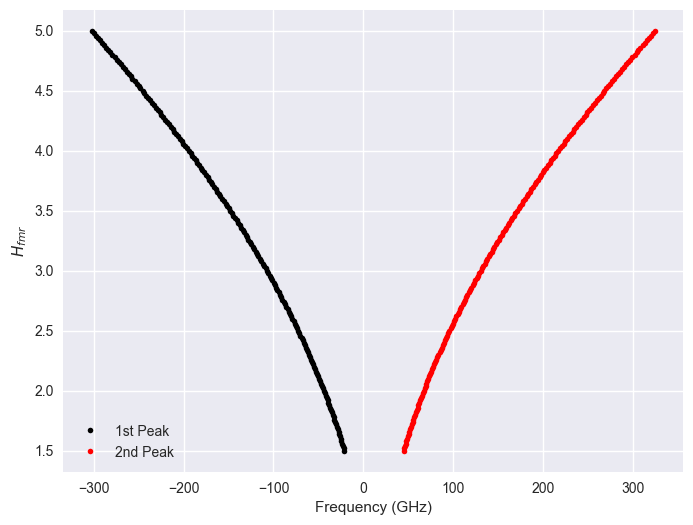

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
fit = pd.read_csv(filepath)

# Extract columns
Hfmr1 = fit.loc[:, 'H_fmr 1'].values
Hfmr2 = fit.loc[:, 'H_fmr 2'].values
deltaH1 = fit.loc[:, 'DeltaH 1']
deltaH2 = fit.loc[:, 'DeltaH 2']
f = fit.loc[:, 'Frequency (GHz)']

def outliers(data): 
    return (data >= (np.mean(data) + 3*np.std(data))) | (data <= (np.mean(data) - 3*np.std(data)))

# Filter out outliers
f1_filtered = f[~outliers(Hfmr1)]
f2_filtered = f[~outliers(Hfmr2)]
Hfmr1_filtered = Hfmr1[~outliers(Hfmr1)]
Hfmr2_filtered = Hfmr2[~outliers(Hfmr2)]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(Hfmr1_filtered, f1_filtered, 'ko', markersize=4, label='1st Peak')
plt.plot(Hfmr2_filtered, f2_filtered, 'ro', markersize=4, label='2nd Peak')
plt.xlabel('Frequency (GHz)')
plt.ylabel('$H_{fmr}$')
plt.legend()
plt.grid(True)

### Linear Fit

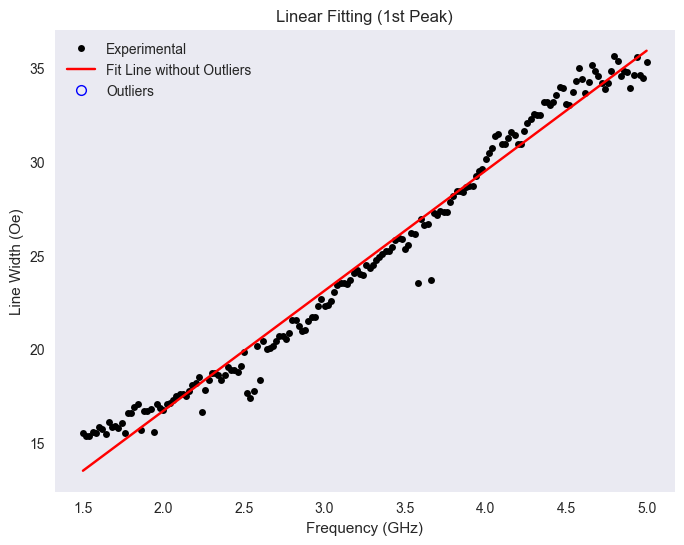

Results:

Slope: 6.3960
Intercept: 3.9312
alpha:  1.7916e-02


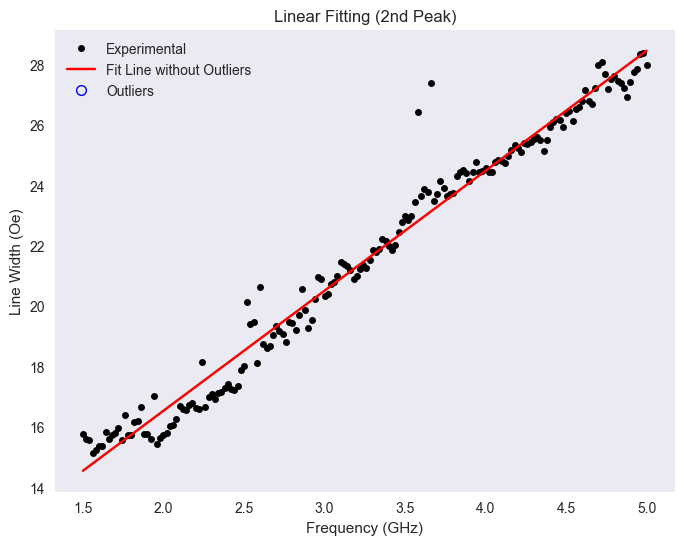

Results:

Slope: 3.9722
Intercept: 8.5984
alpha:  1.1127e-02


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Linear Regression for 1st peak
slope, intercept, r_value, p_value, std_err = linregress(f, deltaH1)
fit_line = slope * f + intercept

# Identify and remove outliers
outliers = abs(deltaH1 - fit_line) > 3*np.std(deltaH2)

# Filter out outliers
f_filtered = f[~outliers]
deltaH1_filtered = deltaH1[~outliers]

# Run linear regression again with filtered data
slope_filtered, intercept_filtered, _, _, _ = linregress(f_filtered, deltaH1_filtered)

# Create the new fit line using the updated slope and intercept
fit_line_filtered = slope_filtered * f + intercept_filtered

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(f, deltaH1, 'ko', markersize=5, label='Experimental')
# plt.plot(f, fit_line, label='Original Fit Line')
plt.plot(f, fit_line_filtered, 'r-', label='Fit Line without Outliers')
plt.plot(f[outliers], deltaH1[outliers], 'bo', label='Outliers', markerfacecolor='none', markeredgewidth=1)
plt.title('Linear Fitting (1st Peak)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Line Width (Oe)')
plt.legend()
plt.grid(False)
plt.show()

# Linear Regression Results
print('Results:\n')
print(f'Slope: {slope_filtered:.4f}')
print(f'Intercept: {intercept_filtered:.4f}')

gamma = 17.6E-3
alpha = (gamma*slope_filtered)/(2*np.pi)
print(f'alpha: {alpha: .4e}')


##############################################


# Linear Regression for 2nd peak
slope, intercept, r_value, p_value, std_err = linregress(f, deltaH2)
fit_line = slope * f + intercept

# Identify and remove outliers
outliers = abs(deltaH2 - fit_line) > 3*np.std(deltaH2)

# Filter out outliers
f_filtered = f[~outliers]
deltaH2_filtered = deltaH2[~outliers]

# Run linear regression again with filtered data
slope_filtered, intercept_filtered, _, _, _ = linregress(f_filtered, deltaH2_filtered)

# Create the new fit line using the updated slope and intercept
fit_line_filtered = slope_filtered * f + intercept_filtered

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(f, deltaH2, 'ko', markersize=5, label='Experimental')
# plt.plot(f, fit_line, label='Original Fit Line')
plt.plot(f, fit_line_filtered, 'r-', label='Fit Line without Outliers')
plt.plot(f[outliers], deltaH2[outliers], 'bo', label='Outliers', markerfacecolor='none', markeredgewidth=1)
plt.title('Linear Fitting (2nd Peak)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Line Width (Oe)')
plt.legend()
plt.grid(False)
plt.show()

# Linear Regression Results
print('Results:\n')
print(f'Slope: {slope_filtered:.4f}')
print(f'Intercept: {intercept_filtered:.4f}')

gamma = 17.6E-3
alpha = (gamma*slope_filtered)/(2*np.pi)
print(f'alpha: {alpha: .4e}')